In [13]:
## SETUP
# conda create -n stats python=2 pip numpy matplotlib pandas scipy scikit-learn seaborn jinja2 ipykernel
# source activate stats
# pip install bootstrapped

#%matplotlib notebook
%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.sparse import coo_matrix
from scipy.stats import pearsonr
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

from math import sqrt
import shutil
import json
import os, sys, re
display(HTML("<style>.container { width:100% !important; }</style>"))
# display multiple dataframes next to each other
#CSS = """
#.output {
#    flex-direction: row;
#}
#"""
#HTML('<style>{}</style>'.format(CSS))

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [627]:
#task = 'RELATEDNESS/SICK'
#task = 'ENTAILMENT/SICK'
#task = 'SENTIMENT/IMDB'
task = 'RE/SEMEVAL2010T8'
#task = 'RE_DEP/SEMEVAL2010T8'
#task = 'ALL'
print('task: %s' % task)

# load data from server
LOAD_DATA = False
SAVE_DF_DROPPED = False

TEST_ALL_VALID = False
TEST_BASE_MODELS = False
TEST_BASE_VARIANTS = False
TEST_CS = False
TEST_LCA = False
TEST_RED = False
TEST_COMPETITOR = False

SELECT_BEST_RED = True
SELECT_BEST_L = False
SELECT_SPLITS = None
#SELECT_SPLITS = ['0,1', '2,3', '4,5']
SELECT_LINKING = None
#SELECT_LINKING = 'DIRECT'
#SELECT_LINKING = 'EDGES'
SELECT_DIR_CLEAN = None
#SELECT_DIR_CLEAN = 'RNN'
SET_D_TO_T = None
#SET_D_TO_T = {'feat': ['-'], 'dir_clean': ['RECNN']}
SELECT_NOSPAN = True



CHECK_BEST_RUNS = True
    
server_adress = 'gpu' # defined in ~/.ssh/config
    
if TEST_BASE_MODELS or TEST_BASE_VARIANTS or TEST_ALL_VALID:
    
    SELECT_BEST_L = False
    SELECT_DIR_CLEAN = None
    SELECT_NOSPAN = True
    SELECT_LINKING = None
    SET_D_TO_T = None
    SELECT_SPLITS = None
if TEST_BASE_MODELS:
    TEST_BASE_VARIANTS = False
    SELECT_LINKING = 'DIRECT'
    if not task == 'ALL':
        SELECT_BEST_RED = False
#if not TEST_BASE_MODELS:
    #SELECT_BEST_L = True
#    SELECT_BEST_RED = True
if SELECT_BEST_L:
    SELECT_LINKING = None



path_server = '~/train/FINAL/'
path = '/mnt/DATA/ML/experiments/FINAL/'
path_data = '/mnt/DATA/ML/data/corpora_out/FINAL'
#path = '/mnt/DATA/ML/experiments/SEARCH/'

parameters_final = ['model', 'linking', 'structure']
parameters_dev = ['model', 'linking', 'structure', 'st', 'fc', 'nfv', 'vvr', 'vvz', 'lr', 'kp', 'd']
metrics_general = ['time_s', 'steps_train', 'time_step_s']
dev = not '/FINAL' in path 
#best_only = True
best_only = False
print('dev=%s' % dev)
task_settings = {'RELATEDNESS/SICK': 
                     {'file': 'relatedness.tsv',
                      'metrics': ['test_pearson_r', 'test_mse', 'abs_error'] + metrics_general,
                      'metrics_dev': ['dev_best_pearson_r', 'dev_best_mse'] + metrics_general,
                      'parameters': parameters_dev if dev else parameters_final,
                      'data': {'DIRECT': 'SICK_RDF/corenlp_noner_recemb_mc2', 'EDGES': 'SICK_RDF/corenlp_noner_recemb_edges_mc2'},
                      'best_red': 'MAX',
                      'best_l': 'DIRECT',
                      'data_max': {'length': 50, 'depth': 20},
                      'best_competitor': {'map': '-', 'red': 'SUM'},
                     },
                    'ENTAILMENT/SICK': 
                     {'file': 'entailment.tsv',
                      'metrics': ['test_accuracy_t50'] + metrics_general,
                      'metrics_dev': ['dev_best_accuracy_t50'] + metrics_general,
                      'parameters': parameters_dev if dev else parameters_final,
                      'data': {'DIRECT': 'SICK_RDF/corenlp_noner_recemb_mc2', 'EDGES': 'SICK_RDF/corenlp_noner_recemb_edges_mc2'},
                      'best_red': 'SUM',
                      'best_l': 'EDGES',
                      'data_max': {'length': 50, 'depth': 20},
                      'best_competitor': {'map': 'GRU', 'red': '-'},
                     },
                  'SENTIMENT/IMDB': 
                     {'file': 'sentiment.tsv',
                      'metrics': ['test_accuracy_t50'] + metrics_general,
                      'metrics_dev': ['dev_best_accuracy_t50'] + metrics_general,
                      'parameters': parameters_dev if dev else parameters_final,
                      'filters_in': [{'sl': ['500']}, {'dpth': ['50']}],
                      'data': {'DIRECT': 'IMDB_RDF/corenlp_noner_recemb_mc20', 'EDGES': 'IMDB_RDF/corenlp_noner_recemb_edges_mc20'},
                      'best_red': 'MAX',
                      'best_l': 'EDGES',
                      'data_max': {'length': 500, 'depth': 50},
                      'best_competitor': {'map': 'GRU', 'red': '-'},
                     },
                  'RE/SEMEVAL2010T8':
                   {'file': 're_semeval2010t8.tsv',
                     'metrics': ['f1_macro', 'f1_wo_norelation_micro', 'test_f1_t33'] + metrics_general,
                     #'metrics': ['test_f1_t33', 'time_s'],
                     'metrics_dev': ['dev_best_f1_t33'] + metrics_general,
                     'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                     'parameters': parameters_dev if dev else parameters_final,
                     #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                     'filters_out': [{'a': ['EDG'], 'l': ['EDGES', 'DIRECT']}, 
                                     {'dir_clean': ['RECNN'], 'd': ['T']}, 
                                     {'feat': ['CS', 'CS-X', 'CS-IS', 'CS-IS-X'], 'd': ['F']},
                                     {'feat': ['BD-CS-IS-REG-WD', 'CS-REG', 'BD-CS-WD', 'BD-CS-REG', 'BD-CS', 'CS', 'BD-CS-REG-WD', 'BD-CS-IS-WD'], 'n': [3000]}
                                    ],
                     'data': {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2_FULLTREE', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2',
                              'DIRECT_LCA': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES_LCA': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED',
                              'SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     'best_red': 'MAX',
                     'best_l': 'EDGES',
                     'data_max': {'length': 50, 'depth': 20},
                     'best_competitor': {'map': 'GRU', 'red': '-'},
                     },
                 'RE_DEP/SEMEVAL2010T8':
                   {'file': 're_dep_semeval2010t8.tsv',
                     'metrics': ['f1_macro', 'test_recall@1'] + metrics_general,
                     #'metrics': ['test_f1_t33', 'time_s'],
                     'metrics_dev': ['dev_best_f1_t33'] + metrics_general,
                     #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                     'parameters': parameters_dev if dev else parameters_final,
                     #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                     'data': {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED','SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     'best_red': 'MAX',
                     'best_l': 'EDGES',
                     'data_max': {'length': 50, 'depth': 20},
                     },
                 'ALL':
                   {'file': 'ALL_BASE' if TEST_BASE_MODELS else 'ALL',
                      'metrics': ['metric_main'] + metrics_general,
                      #'metrics': ['test_f1_t33', 'time_s'],
                      'metrics_dev': None,
                      #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                      'parameters': parameters_dev if dev else parameters_final,
                      #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                     'data': None,# {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED','SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     'best_red': 'MAX',
                     'best_l': 'EDGES',
                     },
                  #'RE/tacred':
                  # {'path': path + 're_tacred.tsv',
                  #    'metrics': ['test_f1_t33', 'time_s'],
                  #    'metrics_dev': ['dev_best_f1_t33', 'f1_wo_norelation_macro', 'f1_wo_norelation_micro', 'time_s'],
                  #    'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                  #    'parameters': parameters_dev if dev else parameters_final,
                  #   },
                 }

#settings = {
    #'path': '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv',
    #'path': '/mnt/DATA/ML/experiments/SEARCH/RE/SEMEVAL2010T8/re_semeval_search.tsv',
    #'path': '/mnt/DATA/ML/experiments/FINAL/entailment.tsv',
    #'metrics_task': ['pearson_r'],
    #'metrics': ['dev_best_f1_t33', 'time_s'],
    
    #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1'},
    #'metric_dev': 'dev_best_pearson_r',
    #'parameters': ['data', 'te', ''], # entries from run_desc
    #'parameters': ['m', 'st', 'fc', 'dir', 'l', 'nfv', 'vvr', 'vvz']
    #'parameters':
    #'select': {'m': ['GRU', 'SUM-GRU']}
#}

task_setting = task_settings[task]
#path = '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv'
#metrics_task = ['pearson_r']
fn = task_setting['file']
fn_path = os.path.join(path, fn)
print('fn_path: %s' % fn_path)

#metrics_task = settings['metrics_task']
if dev:
    metrics = task_setting['metrics_dev']
else:
    metrics = task_setting['metrics']
metric_main = metrics[0]
print('use metrics: %s' % metrics)
print('metric_main: %s' % metric_main)
metrics_alternative = task_setting.get('metrics_alternative', {})
parameters = task_setting['parameters']
print('use parameters: %s' % parameters)
select = task_setting.get('select', {})
metrics_inverted = ['time_s', 'steps_train', 'time_step_s']

metrics_dev = task_setting.get('metrics_dev', [])

best_red = task_setting.get('best_red', None)
print('best_red: %s' % best_red)
best_competitor = task_setting.get('best_competitor', None)
print('best_competitor: %s' % str(best_competitor))

data_max = task_setting.get('data_max', None)

filters_in = task_setting.get('filters_in', None)
filters_out = task_setting.get('filters_out', None)

task: RE/SEMEVAL2010T8
dev=False
fn_path: /mnt/DATA/ML/experiments/FINAL/re_semeval2010t8.tsv
use metrics: ['f1_macro', 'f1_wo_norelation_micro', 'test_f1_t33', 'time_s', 'steps_train', 'time_step_s']
metric_main: f1_macro
use parameters: ['model', 'linking', 'structure']
best_red: MAX
best_competitor: {'map': 'GRU', 'red': '-'}


In [587]:
# get result files from server
if LOAD_DATA and task != 'ALL':
    #assert path.endswith('/'), 'path has to end with "/" to copy files'
    if not path.endswith('/'):
        path += '/'
    print('copy file(s) to: %s' % path)
    # copy all files
    #!scp {server_adress}:'{path_server}*.tsv' {path}
    # copy only task file
    !scp {server_adress}:{path_server}{fn} {path}
    print('DONE')

In [588]:
def check_groups(df):
    grouped = df.groupby(COLUMN_RUN_DESC)
    temp = []
    for group_key in grouped.groups:
        
        group = grouped.get_group(group_key)
        if len(group) > 1:
            print('group_key: %s' % group_key)
            print(group)
            
            #temp.append(group)
            break
    #pd.concat(temp)
    #temp = pd.concat(temp)

In [589]:


if task != 'ALL':
    df_loaded = pd.read_csv(fn_path, sep='\t')
    print(len(df_loaded))


    #df_loaded.apply(lambda row: row['dev_best_recall@1'] or row['dev_best_f1_t33'],axis=1)
    for m_alt in metrics_alternative: 
        df_loaded[m_alt].fillna(df_loaded[metrics_alternative[m_alt]], inplace=True)

    def get_current_values(df):
        return {p: list(set(df[p])) for p in parameters}
    
    # fix double entries: keep only first run per path and run_description
    len_before_grouping = len(df_loaded)
    df_loaded = df_loaded.groupby(['run_description', 'path']).first().reset_index()
    print('keep only first runs per path and run_desc. keep: %i, removed: %i' % (len(df_loaded), len_before_grouping - len(df_loaded)))
    
    df_loaded['dir_clean'] = df_loaded['dir'].replace('\d+', '', regex=True)
    if task == 'RE/SEMEVAL2010T8':
        print('rename dir_clean entries: RECNN -> RECNN_LCA, RECNN_FULLTREE -> RECNN')
        indices_recnn = df_loaded[df_loaded['dir_clean'] == 'RECNN']
        indices_recnn_fulltree =  df_loaded[df_loaded['dir_clean'] == 'RECNN_FULLTREE']
        df_loaded.loc[df_loaded['dir_clean'] == 'RECNN', 'dir_clean'] = 'RECNN_LCA' #['RECNN_LCA'] * np.count_nonzero(indices_recnn)
        df_loaded.loc[df_loaded['dir_clean'] == 'RECNN_FULLTREE', 'dir_clean'] = 'RECNN'
        
        # overwrite LM with RECNN TODO: later use LM_LCA_NEW _> RECNN_LCA
        df_loaded.loc[df_loaded['dir_clean'] == 'LM_LCA_NEW', 'dir_clean'] = 'RECNN_LCA'
        #df_loaded = df_loaded[df_loaded['dir_clean'] != 'LM']
        #df_loaded['dir_clean'][indicesindices_recnn_fulltree_recnn] = 'RECNN'
    elif task == 'RE_DEP/SEMEVAL2010T8':
        df_loaded.loc[df_loaded['dir_clean'] == 'LM', 'dir_clean'] = 'RECNN_LCA'
    # exclude: dir==RECNN_FULLTREE
    #df_loaded = df_loaded[df_loaded['dir'] != 'RECNN_FULLTREE']
    #df_loaded.drop(df_loaded[df_loaded['dir'] == 'RECNN_FULLTREE'].index, axis=0, inplace=True)
    #df_loaded.reset_index(drop=True, inplace=True)
    if 'time_step_s' in metrics:
        if 'steps_train' in df_loaded and 'time_s' in df_loaded:
            print('create time_step_s from time_s and steps_train')
            df_loaded['time_step_s'] = df_loaded.apply(lambda row: row['time_s'] / row['steps_train'], axis=1)
        else:
            print('WARNING: could not create time_step_s from time_s and steps_train because one of them is missing')
else:
    df_loaded_list = []
    for fn in os.listdir(fn_path):
        fn_full = os.path.join(fn_path, fn)
        print('load: %s' % fn_full)
        df_loaded_temp = pd.read_pickle(fn_full)
        task_temp = fn.replace('-', '/')
        df_loaded_temp['task'] = task_temp
        #display(df_loaded_temp[:5])
        # defaults (for task != RE/SEMEVAL2018T8)
        if 'ct' not in df_loaded_temp:
            print('set ct=TREE for %s...' % fn)
            df_loaded_temp['ct'] = 'TREE'
        if 'dir_clean' not in df_loaded_temp:
            df_loaded_temp['dir_clean'] = 'RECNN'
        if 'd' not in df_loaded_temp:
            df_loaded_temp['d'] = 'F'
        if 'n' not in df_loaded_temp:
            df_loaded_temp['n'] = '10000'
        
        # take only entries with best reduction function
        if SELECT_BEST_RED:
            df_loaded_temp = df_loaded_temp[df_loaded_temp['red'].isin(['-', task_settings[task_temp]['best_red']])]
            
        if SELECT_BEST_L:
            df_loaded_temp = df_loaded_temp[df_loaded_temp['l'] == task_settings[task_temp]['best_l']]
        
        df_loaded_list.append(df_loaded_temp)
    df_loaded = pd.concat(df_loaded_list, axis=0).fillna('-')
    run_desc_cols = ['n']
print('loaded %i records' % len(df_loaded))
    #set(df_loaded['dir_clean'])
df_loaded[:5]
#df_loaded.groupby('ct').count()
#set(df_loaded['ct'])

2580
keep only first runs per path and run_desc. keep: 2530, removed: 50
rename dir_clean entries: RECNN -> RECNN_LCA, RECNN_FULLTREE -> RECNN
create time_step_s from time_s and steps_train
loaded 2530 records


,run_description,path,add_heads,bidirectional,dev_best_accuracy_t33,dev_best_accuracy_t50,dev_best_accuracy_t66,dev_best_f1_t33,dev_best_f1_t50,dev_best_f1_t66,dev_best_precision_t33,dev_best_precision_t50,dev_best_precision_t66,dev_best_recall@1,dev_best_recall@2,dev_best_recall@3,dev_best_recall@5,dev_best_recall_t33,dev_best_recall_t50,dev_best_recall_t66,dev_file_indices,dir,f1_macro,f1_wo_norelation_micro,fc_sizes,keep_prob,leaf_fc_size,nbr_trees,run_desc,steps_train,test_accuracy_t33,test_accuracy_t50,test_accuracy_t66,test_f1_t33,test_f1_t50,test_f1_t66,test_precision_t33,test_precision_t50,test_precision_t66,test_recall@1,test_recall@2,test_recall@3,test_recall@5,test_recall_t33,test_recall_t50,test_recall_t66,time_s,tree_embedder,dir_clean,time_step_s
0,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,"EDG,ARGS",NaN,0.972335,0.973257,0.974178,0.744299,0.742640,0.742370,0.724689,0.752405,0.781617,NaN,NaN,NaN,NaN,0.765000,0.733125,0.706875,"0,1",RECNN_FULLTREE2,0.7863,0.7944,NaN,0.5,NaN,NaN,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spFULLTREE2,2240,0.972221,0.973345,0.974275,0.743236,0.743614,0.744365,0.723657,0.753021,0.780291,NaN,NaN,NaN,NaN,0.763904,0.734438,0.711602,655.856435,HTU_reduceMAX_mapGRU_is,RECNN,0.292793
1,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,"EDG,ARGS",NaN,0.970888,0.972303,0.972862,0.733674,0.729955,0.721001,0.707487,0.749671,0.785556,NaN,NaN,NaN,NaN,0.761875,0.711250,0.666250,"0,1",RECNN_FULLTREE2,0.7825,0.7935,NaN,0.5,NaN,NaN,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spFULLTREE2,1408,0.971484,0.973229,0.973694,0.739323,0.739286,0.730058,0.712432,0.758327,0.793685,NaN,NaN,NaN,NaN,0.768324,0.721179,0.675875,478.122662,HTU_reduceMAX_mapGRU_is,RECNN,0.339576
2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,"EDG,ARGS",NaN,0.972763,0.974507,0.975033,0.750151,0.751682,0.744702,0.725204,0.771203,0.806264,NaN,NaN,NaN,NaN,0.776875,0.733125,0.691875,"0,1",RECNN_FULLTREE2,0.7921,0.7994,NaN,0.5,NaN,NaN,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spFULLTREE2,1472,0.972763,0.974140,0.974527,0.749866,0.747921,0.739182,0.725706,0.767947,0.801550,NaN,NaN,NaN,NaN,0.775691,0.728913,0.685820,492.051388,HTU_reduceMAX_mapGRU_is,RECNN,0.334274
3,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/3,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,"EDG,ARGS",NaN,0.972467,0.973257,0.974013,0.746133,0.742640,0.740132,0.724808,0.752405,0.781250,NaN,NaN,NaN,NaN,0.768750,0.733125,0.703125,"0,1",RECNN_FULLTR

In [590]:

#df_loaded[-5:]
#df_loaded.groupby('red').count()

#df_loaded[['tree_embedder', metrics[0]]].groupby('tree_embedder').count()
#df_loaded[df_loaded['tree_embedder'] == 'HTUBatchedHead_reduceMAX_mapGRU'][:10]
#set(df_loaded['dir_clean'])
#len(df_loaded[df_loaded['run_description'].str.contains('dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREVREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF')])
#df_loaded[~df_loaded['path'].str.contains('WRONG')][['path', 'run_description']].groupby(['run_description']).count()
#set(df_loaded['dir'])
df_loaded.groupby(['red', 'map', 'feat', 'task', 'l']).count()


KeyError: 'red'

In [591]:
COLUMN_RUN = 'run'
COLUMN_RUN_DESC_COLS = 'run_desc_cols'
COLUMN_DFIDX = 'dfidx'
COLUMN_RUN_DESC = 'run_description'
COLUMN_RUN_DESC_NEW = 'run_desc_new'

#map_value_short = {'CORENLPNONERRECEMBEDGESMC2': 'E', 
#             'CORENLPNONERRECEMBMC2': 'D',
#             #'HTUREDUCEMAXMAPGRU': 'MAX-GRU',
#             #'HTUREDUCESUMMAPGRU': 'SUM-GRU',
#             #'FLATGRU': 'GRU',
#             #'FLATSUM': 'SUM',
#             #'FLATMAX': 'MAX',
#            }
metrics_description = {'f1_macro': 'F1 macro', 'f1_wo_norelation_micro': 'F1 micro w/o no_relation', 'test_f1_t33': 'F1 micro', 'time_s': 'Time in s', 'test_accuracy_t50': 'Accuracy', 'test_pearson_r': "Pearson's r", 'test_mse': 'MSE'}
map_value_long = {'E': 'edges', 'D': 'direct'}
map_param_short = {'data': 'l', 'te': 'm', 'linking': 'l', 'model': 'm', 'structure': 'str'}
map_param_long = {'l': 'linking', 'm': 'model', 'str': 'structure', 'red': 'f_reduce', 'map': 'f_map'}
map_task_long = {'RTE': 'Rogognizing Textual Entailment', 'RP': 'Relatedness Prediction', 'SA': 'Sentiment Analysis', 'RE/semeval': 'Relation Extraction (SemEval)', 'RE/tacred': 'Relation Extraction (TacRED)'}
map_task_short = {'RE': 'RE', 'ENTAILMENT': 'RTE', 'RELATEDNESS': 'RP', 'SENTIMENT': 'SA'}
map_structure_to_order_awareness = {'BOW': 'NONE', 'RNN': 'FULL', 'RECNN': 'PARTLY'}
map_ct_to_order_awareness = {'TREE': 'PARTLY', 'FLAT': 'FULL'}
parameters = [map_param_short.get(p, p) for p in parameters]


def filter_iter(df, filters):
    for filter_dicts in filters:
        if isinstance(filter_dicts, dict):
            filter_dict_in = filter_dicts
            filter_dict_out = {}  
        else:
            filter_dict_in, filter_dict_out = filter_dicts
      
        filter_in = np.ones(len(df), dtype=bool)
        filter_out = np.zeros(len(df), dtype=bool)
        for k in filter_dict_in:
            filter_in = filter_in & df[k].isin(filter_dict_in[k])
        for k in filter_dict_out:
            filter_out = filter_out | df[k].isin(filter_dict_out[k])
        #filter_all = filter_all | (filter_in & filter_out)
        yield df[filter_in & ~filter_out], filter_dict_in, filter_dict_out

def format_description(v, vtype=None):
    if isinstance(v, list):
        return ', '.join([format_description(_v, vtype=vtype) for _v in v])
    
    #if vtype == 'm':
    if vtype == 'metric':
        return metrics_description[v]
    if vtype == 'parameter':
        return map_param_long[v]
    if vtype == 'task':
        return map_task_short[v.split('/')[0].upper()]
    if vtype == 'pass':
        return v
    if vtype == 'structure_to_order_awareness':
        return map_structure_to_order_awareness[v]
    if vtype == 'ct_to_order_awareness':
        return map_ct_to_order_awareness[v]
    raise AssertionError('unkown vtype=%s' % vtype)

def as_suffixes(v, suffixes):
    found = []
    for suffix in suffixes:
        if suffix in v:
            found.append(suffixes[suffix])
            v = v.replace(suffix, '')
    return v + (':' + '-'.join(found) if len(found) > 0 else '')

def format_model(m):
    if m.startswith('FLAT'):
        m = 'FLAT:' + m[len('FLAT'):]
    elif m.startswith('HTU'):
        m = m[len('HTU'):]
        m = m.replace('REDUCE','').replace('MAP','-')
        m = as_suffixes(m, {'REV':'REV', 'WD':'WD', 'IS':'IS', 'PL':'PL'})
        if m.startswith('BATCHEDHEADX'):
            m = 'LM:' + m[len('BATCHEDHEADX'):] + (':' if len(m.split(':')) == 1 else '-') + 'REG'
        elif m.startswith('BATCHEDHEAD'):
            m = 'LM:' + m[len('BATCHEDHEAD'):]
        else:
            m = 'TREE:' + m
       
    return m

def format_data(v):
    if 'SPAN' in v:
        return 'SPAN'
    if 'EDGES' in v:
        return 'EDGES'
    return 'DIRECT'

def get_value_short(v, t=None):
    res = v
    #try:
    #    float(v)
    #    return v
    #except ValueError:
    #    pass
     
    if isinstance(res, str):
        if t == 'te':
            res = format_model(res)
        elif t == 'data':
            res = format_data(v)
        elif t == 'mt':
            if v.upper() in ['MULTICLASS', 'MCLASS']:
                res = 'CLASS'
            else:
                res = v
        else:
            parts = res.split('-')
            if parts[0] != '':
                res = ','.join(parts)
        #res = format_model(res)
        
    return res

def get_structure_type(v):
    if v.startswith('TREE:'):
        return 'RECNN'
    if v.startswith('LM'):
        return 'LM'
    if v.startswith('FLAT:'):
        if v.startswith('FLAT:GRU') or v.startswith('FLAT:LSTM'):
            return 'RNN'
        if v.startswith('FLAT:SUM') or v.startswith('FLAT:MAX'):
            return 'BOW'
        raise AssertionError('unknown flat model: %s' % v)
    raise AssertionError('unknown model: %s' % v)

def value_to_string(v):
    return str(v).replace(',', '-').upper()

def run_desc_to_string(run_desc_dict, keys=None):
    if keys is None:
        keys = sorted(list(run_desc_dict))
    return '_'.join([k + value_to_string(run_desc_dict[k]) for k in keys])

def run_desc_to_dict(run_desc):
    _res = {}
    parts = run_desc.split('/')
    if len(parts) == 2:
        _res[COLUMN_RUN] = parts[1]
    elif len(parts) > 2:
        print('WARNINING: more then 2 parts for split with "/": %s' % run_desc)
    else:
        print('WARNINING: no split_idx found: %s' % run_desc)
    run_desc = parts[0]
    parts = re.split(r'(_|^)([a-z]+)', run_desc)
    #new_entries = {parts[i-1]: ','.join(parts[i].strip().split('-')) for i in range(3, len(parts), 3)}
    new_entries = {map_param_short.get(parts[i-1], parts[i-1]): get_value_short(parts[i], parts[i-1]) for i in range(3, len(parts), 3)}
    _res.update(new_entries)
    cols_run_desc = sorted([k for k in new_entries if k not in [COLUMN_RUN, COLUMN_DFIDX]])
    _res[COLUMN_RUN_DESC_NEW] = run_desc_to_string(_res, keys=cols_run_desc)
    _res[COLUMN_RUN_DESC_COLS] = ','.join(cols_run_desc)
    #_res[COLUMN_RUN_DESC_NEW] = '_'.join([col + _res[col] for col in cols_run_desc])
    
    return _res

#run_desc_to_dict('a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBEDGESMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0')
#pd.DataFrame(df['run_description'].apply(run_desc_to_dict))#, axis=1, result_type='expand')


def model_to_features(model):
    res = {}
    parts = model.split(':')
    
    #res['rm'] = parts[1]
    feats = []
    if len(parts) > 2:
        feats = parts[2].split('-')
    
    # save LM (language model) as CS (consistency scoring) feature
    if parts[0] == 'LM':
        feats.append('CS')
        res['ct'] = 'TREE'
    else:
        res['ct'] = parts[0]
    
    if len(feats) == 0:
        res['feat'] = '-'
    else:
        res['feat'] = '-'.join(sorted(feats))
    res['map'] = '-'
    for mf in ['GRU', 'LSTM']:
        if mf in parts[1]:
            res['map'] = mf
            break
    res['red'] = '-'
    for rf in ['MAX', 'AVG', 'SUM']:
        if rf in parts[1]:
            res['red'] = rf
            break
    
    return res

def get_filter(df, filter_dict):
    bool_filter = np.ones(len(df_all), dtype=bool)
    for filter_key in filter_dict:
        bool_filter = bool_filter & df[filter_key].isin(filter_dict[filter_key])
    print('filter: %s. select %i of %i rows' % (filter_dict, np.count_nonzero(bool_filter), len(df)))
    return bool_filter

def fix_feat(feat):
    feat_parts = [fe for fe in feat.split('-') if fe !='']
    if len(feat_parts) == 0:
        return '-'
    return '-'.join(sorted(feat_parts))

if task != 'ALL':
    df_runddesc = pd.DataFrame([run_desc_to_dict(rd) for rd in df_loaded[COLUMN_RUN_DESC]])
    df_model = pd.DataFrame([model_to_features(rd) for rd in df_runddesc['m']])
    #metrics_test = ['test_' + m for m in metrics_task]
    #metrics_dev_best = ['dev_best_' + m for m in metrics_task]
    #metrics_performance = metrics_dev_best + metrics_test
    #metrics_resources = ['steps_train', 'time_s'] 
    #metrics_all = metrics_performance + metrics_resources
    take_columns = list(metrics) + ['dir_clean', 'dir', 'path', COLUMN_RUN_DESC]
    for m in task_setting['metrics_dev']:
        if m not in metrics:
            take_columns.append(m)
    df_all = pd.concat([df_model, df_loaded[take_columns], df_runddesc], axis=1)
    #display(df_all.groupby(['m']).count())
    # add structure column
    #display(len(df_all[df_all['m'].isnull()]))
    df_all['str'] = df_all.apply(lambda row: get_structure_type(row['m']), axis=1)
    
    # set directionality to True, if WD (distinct mappings for directionaility enforce d=True internally)
    df_all.loc[df_all['feat'].str.contains('WD'), 'd'] = 'T'

    if best_only:
        print('keep only runs with max %s ...' % task_setting['metrics_dev'])
        n = len(df_all)
        df_all = df_all.sort_values(task_setting['metrics_dev'], ascending=False).drop_duplicates(['run_desc', 'run'])
        print('removed %i of %i runs (%i remaining)' % (n - len(df_all), n, len(df_all)))
    else:
        print('loaded %i runs' % len(df_all))
    
   
    # remove (wrong) entries with max metric 
    df_all = df_all[df_all[metrics[0]] < 1.0]
    if filters_in is not None:
        print('use filters_in: %s' % filters_in)
        bool_filter = np.zeros(len(df_all), dtype=bool)
        for filter_in in filters_in:
            bool_filter = bool_filter | get_filter(df_all, filter_in)
        df_all = df_all[bool_filter]
        #filtered_dfs = [] 
        #for fil in filters_in:
        #    filtered_df = df_all
        #    for fil_k in fil:
        #        filtered_df = filtered_df[filtered_df[fil_k].isin(fil[fil_k])]
        #    filtered_dfs.append(filtered_df)
        #df_all = pd.concat(filtered_dfs)
    #print(len(df_all))
    print(set(df_all['l']))
    if filters_out is not None:
        print('use filters_out: %s' % filters_out)
        bool_filter = np.zeros(len(df_all), dtype=bool)
        for filter_out in filters_out:
            bool_filter = bool_filter | get_filter(df_all, filter_out)
        df_all = df_all[~bool_filter]
        
        #filtered_dfs = [] 
        #for fil in filters_out:
        #    filtered_df = df_all
        #    for fil_k in fil:
        #        filtered_df = filtered_df[filtered_df[fil_k].isin(fil[fil_k])]
        #    filtered_dfs.append(filtered_df)
        #df_out_indices = pd.concat(filtered_dfs).index
        #df_all.drop(df_out_indices, inplace=True)

    # drop model column because it was split into ct, map, reduce, and feat


    df_all.reset_index(drop=True, inplace=True)
    print('%i records remain' % len(df_all))
    
    print(set(df_all['l']))
    
    #df_all.apply (lambda row: row['dev_best_recall@1'],axis=1)
    #df_all[:20]#.describe()
    #set(df_all['m'])
    #df_all[:100]
    #print('%i runs' % len(df_all))
    #df_all[df_all['str'] == 'BOW'][:10]
    #len(df_all)
    #df_all['run_desc'][:10].values
    #set(df_all['kpb'])
    run_desc_cols = df_all[COLUMN_RUN_DESC_COLS][0].split(',')
    # move model column to front
    run_desc_cols.insert(0, run_desc_cols.pop(run_desc_cols.index('m')))
    print('run_desc_cols: %s' % run_desc_cols)
    df_all.drop(columns=[COLUMN_RUN_DESC_COLS], inplace=True)
    
         # take only entries with bets reduction function
    if SELECT_BEST_RED:
        df_all = df_all[df_all['red'].isin(['-', task_settings[task]['best_red']])]

    if SELECT_BEST_L:
        df_all = df_all[df_all['l'] == task_settings[task]['best_l']]
    
    df_all.reset_index(drop=True, inplace=True)
    
    for col in df_all:
        if len(df_all) == len(df_all[df_all[col].isnull() | (df_all[col] == '')]):
            print('delete col "%s", it contains only nan / empty values' % col)
            df_all.drop(columns=[col], inplace=True)
        #else:
        #    display(set(df_all['ec']))
        
    #if SET_D_TO_T is not None:
    #    df_all.loc[get_filter(df_all, SET_D_TO_T), 'd'] = 'T'
   
    
    #df_all['feat_new'] = df_all.apply(lambda row: append_d_to_feats(row), axis=1)
    
    # add BD for d==True (RECNN_LCA only!)
    indices = ((df_all['dir_clean'] == 'RECNN_LCA') & (df_all['d'] == 'T')) | (df_all['feat'].str.contains('WD'))
    df_all.loc[indices, 'feat'] = df_all.loc[indices, 'feat'] + '-BD'
    df_all.drop(columns='d', inplace=True)    
    indices = (df_all['dir_clean'] == 'RECNN_LCA') & (~df_all['feat'].str.contains('CS'))
    df_all.loc[indices, 'feat'] = df_all.loc[indices, 'feat'] + '-LCA'
    df_all.loc[indices, 'dir_clean'] = 'RECNN'
    df_all['feat'] = df_all.apply(lambda row: fix_feat(row['feat']), axis=1)

else:
    df_all = df_loaded
    
#len(df_all[df_all['feat'].str.contains('REV')])
#print(set(df_all['m']))
#print(set(df_all['ct']))
#print(set(df_all['feat']))
#len(df_all)
df_all[:5]
#set(df_all['ct'])
#df_filtered.groupby(['task', 'map', 'ct', 'feat', 'red']).count()
#df_all.groupby('ct').count()

loaded 2530 runs
set(['EDGES', 'SPAN', 'DIRECT'])
use filters_out: [{'a': ['EDG'], 'l': ['EDGES', 'DIRECT']}, {'dir_clean': ['RECNN'], 'd': ['T']}, {'feat': ['CS', 'CS-X', 'CS-IS', 'CS-IS-X'], 'd': ['F']}, {'feat': ['BD-CS-IS-REG-WD', 'CS-REG', 'BD-CS-WD', 'BD-CS-REG', 'BD-CS', 'CS', 'BD-CS-REG-WD', 'BD-CS-IS-WD'], 'n': [3000]}]
filter: {'a': ['EDG'], 'l': ['EDGES', 'DIRECT']}. select 450 of 2530 rows
filter: {'dir_clean': ['RECNN'], 'd': ['T']}. select 150 of 2530 rows
filter: {'feat': ['CS', 'CS-X', 'CS-IS', 'CS-IS-X'], 'd': ['F']}. select 30 of 2530 rows
filter: {'feat': ['BD-CS-IS-REG-WD', 'CS-REG', 'BD-CS-WD', 'BD-CS-REG', 'BD-CS', 'CS', 'BD-CS-REG-WD', 'BD-CS-IS-WD'], 'n': [3000]}. select 0 of 2530 rows
1900 records remain
set(['EDGES', 'SPAN', 'DIRECT'])
run_desc_cols: ['m', 'a', 'avf', 'b', 'bs', 'cc', 'clp', 'cm', 'cntxt', 'd', 'dpth', 'dt', 'ec', 'fc', 'kp', 'kpb', 'kpn', 'l', 'lc', 'leaffc', 'lr', 'mt', 'n', 'nfv', 'ns', 'rootfc', 'sl', 'sm', 'st', 'tfidf', 'tk', 'vvr', 'vvz

,ct,feat,map,red,f1_macro,f1_wo_norelation_micro,test_f1_t33,time_s,steps_train,time_step_s,dir_clean,dir,path,run_description,dev_best_f1_t33,a,avf,b,bs,cc,clp,cm,cntxt,dfidx,dpth,dt,fc,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc_new,sl,sm,st,tfidf,tk,vvr,vvz,str
0,TREE,IS,GRU,MAX,0.7863,0.7944,0.743236,655.856435,2240,0.292793,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,0.744299,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,0,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
1,TREE,IS,GRU,MAX,0.7825,0.7935,0.739323,478.122662,1408,0.339576,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,0.733674,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,1,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
2,TREE,IS,GRU,MAX,0.7921,0.7994,0.749866,492.051388,1472,0.334274,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/2,0.750151,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,2,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
3,TREE,IS,GRU,MAX,0.7887,0.7971,0.739457,599.791474,1984,0.302314,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/3,0.746133,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,3,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
4,TREE,IS,GRU,MAX,0.7912,0.8005,0.749955,790.291426,2880,0.274407,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/4,0.760270,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,4,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF

In [592]:
#check_groups(df_all)

#set(df_all['feat_new'])
    #display(temp[:10])
    #temp.drop(columns=metrics + metrics_dev, inplace=True)
    #grouped = temp.groupby('run_desc_new')
    ##grouped.agg(lambda x: '%i: %s' % (len(set(x)), set(x)))
    #grouped.agg(lambda x: '%i: %s' % (len(x), list(x)))

    #for group_key in grouped.groups:
    #    group = grouped.get_group(group_key)
    #    if len(group) > 1:
    #        print(len(group))
    #        display(group)
#df_loaded[~df_loaded['path'].str.contains('WRONG')][['path', 'run_description']].groupby(['run_description']).count()
#df_all[~df_all['path'].str.contains('WRONG')][['path', 'run_description', metrics[0]]].groupby(['run_description', 'path']).count()
print(set(df_all['feat']))
#print(set(df_all['l']))



set(['LCA-REV', 'BD-CS-IS-REG-WD', 'REV', 'BD-LCA-PL', 'BD-WD', 'CS-REG', 'BD-LCA-REV', 'IS-LCA', 'BD-LCA', '-', 'BD-CS-WD', 'BD-CS-REG', 'BD-LCA-WD', 'PL', 'LCA-PL', 'BD-LCA-PL-WD', 'IS', 'BD-CS', 'CS', 'BD-CS-REG-WD', 'BD-CS-IS-WD', 'BD-IS-LCA-WD', 'LCA', 'BD-IS-LCA'])


In [593]:
def _norm(v):
    _min = v.min()
    _max = v.max()
    if _min == _max:
        return np.ones_like(v) * 0.5
    return (v - _min) / (_max - _min)

def color_to_hex(rgba):
    return '#%02x%02x%02x%02x' % (rgba[0]*255,rgba[1]*255,rgba[2]*255,rgba[3]*255)

#def set_white_if_max(vm _max)
#    if 

def colormap_columns(data, cm=sns.light_palette("green", as_cmap=True), columns=metrics, columns_inverted=metrics_inverted, columns_dont_exp=None):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    #print(type(data.name))
    name_main = data.name
    if isinstance(name_main, tuple):
        name_main = name_main[0]
    if columns is not None and name_main not in columns or len(data) <= 1:
        return [''] * len(data)
    
    _data = data.values.astype(float)
    filter_not_nan = ~data.isnull()
    
    if name_main in columns_inverted:
        _data = -data
    data_norm = _norm(_data[filter_not_nan])
    #print(len(_data))
    #print(len(data_norm))
    # rescale exponentially
    if columns_dont_exp is None:
        columns_dont_exp = columns_inverted
    if name_main not in columns_dont_exp: 
        data_norm_scaled = _norm(np.exp(data_norm))
        #print('\trescaled %s for coloring. total dif: %f' % (data.name, np.absolute(data_norm - data_norm_scaled).sum()))
        data_norm = data_norm_scaled
    _max = data_norm.max()
    data_norm_all = np.zeros(len(_data), dtype=data_norm.dtype)
    data_norm_all[filter_not_nan] = data_norm
    # ', color: white' if v == _max else ''
    # 
    return ['background-color: {}'.format(color_to_hex(cm(v))) if not data.isnull()[i] else 'background-color: white' for i, v in enumerate(data_norm_all)]

def max_white(s, columns=None, columns_inverted=metrics_inverted, margin=0.05):
    '''
    Color the maximum in a Series white. Respects columns_inverted and takes a margin value.
    '''
    name_main = s.name
    if isinstance(name_main, tuple):
        name_main = name_main[0]
    if (columns is not None and name_main not in columns) or len(s) <= 1 or not np.issubdtype(s.dtype, np.number):
        return [''] * len(s)
    values = s.values
    filter_not_nan = ~s.isnull()
    if name_main in columns_inverted:
        #print('invert color for col=%s (%s)' % (s.name, columns_inverted))
        values = -values
    values_normed = _norm(values[filter_not_nan])
    set_white = values_normed * (1.0 + margin) >= values_normed.max()
    set_white_all = np.zeros(len(s), dtype=set_white.dtype)
    set_white_all[filter_not_nan] = set_white
    #    set_white = s <= (s.min() + s.std())
    #else:
    #    set_white = s >= (s.max() - s.std())
    return ['color: white' if v else '' for v in set_white_all]

def display_colored(df, columns_inverted=metrics_inverted, columns=('mean_a', 'mean_b')):
    if columns is None:
        columns = list(df)
    float_cols = [col for col in df if df[col].dtype in [np.float64, np.float32]]
    #print(float_cols)
    #formatter = lambda x: "{:.4f}".format(x) if isinstance(x,(flomax_whiteat, np.float)) else x
    formatter = {col: '{:.4f}' for col in float_cols}
    res = df.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0).apply(max_white, columns=columns, columns_inverted=columns_inverted, axis=0).format(formatter)
    display(res)

In [594]:
def swap_stats(df, change_column='change'):
    df = pd.DataFrame(df)
    #change_column_swapped = change_column + '_swapped'
    #df[change_column] = df.index.get_level_values(change_column)
    ## TODO: implement!
    #df[change_column] = df.apply(lambda row: '(' + ' -> '.join(row[change_column][1:-1].split(' -> ')[::-1]) + ')', axis=1)
    
    conv = {idx: '(' + ' -> '.join(idx[1:-1].split(' -> ')[::-1]) + ')' for idx in df.index.get_level_values(change_column)}
    df.rename(index=conv, level=change_column, inplace=True)
    
    for a, b in [('mean_a', 'mean_b'), ('nbr_a', 'nbr_b')]:
        temp =df[a].copy()
        df[a] = df[b]
        df[b] = temp
        #df = df.rename(columns = {a:b})#, inplace = True)
    for col in ['dif', 'dif_%']:
        df[col] = df[col] * -1.0
    
    #df.set_index(df.index.droplevel('change'), inplace=True)
    return df
        
def display_stats(df, metric, sort_by, index_contains=None):
    
    if metric in metrics_inverted:
        _df_dec = df[df['dif'] > 0]
        _df_inc = df[df['dif'] < 0]
        _columns_inverted=['mean_a', 'mean_b']
    else:
        _df_dec = df[df['dif'] < 0]
        _df_inc = df[df['dif'] > 0]
        _columns_inverted=[]
    if 'change' in df.index.names:
        _df_dec_swapped = swap_stats(_df_dec)
        _df_all = pd.concat([_df_dec_swapped, _df_inc])
        if sort_by is not None:
            _df_all = _df_all.sort_values(sort_by)
        
        if hasattr(_df_all.index, 'names') and 'task' in _df_all.index.names:
            #print('create pivot for tasks...')
            _df_all = _df_all[_df_all.index.get_level_values('task')  != '@']
            #_df_all = _df_all.unstack(level='task')
            
        if index_contains is not None:
            for k in index_contains:
                _df_all = _df_all[_df_all.index.get_level_values(k).str.contains(index_contains[k])]
        print('increase of %s:' % metric)
        display_colored(_df_all, columns_inverted=_columns_inverted, columns=('mean_a', 'mean_b', 'dif_%'))        
    else:
        if sort_by is not None:
            _df_dec = _df_dec.sort_values(sort_by)
            _df_inc = _df_inc.sort_values(sort_by)
        if hasattr(_df_dec.index, 'names') and 'task' in _df_dec.index.names:
        #    print('create pivot for tasks...')
            _df_dec = _df_dec[_df_dec.index.get_level_values('task')  != '@']
        #    _df_dec = _df_dec.unstack(level='task')
        print('decrease of %s:' % metric)
        display_colored(_df_dec, columns_inverted=_columns_inverted, columns=('mean_a', 'mean_b', 'dif_%'))
        
        if hasattr(_df_inc.index, 'names') and 'task' in _df_inc.index.names:
        #    print('create pivot for tasks...')
            _df_inc = _df_inc[_df_inc.index.get_level_values('task')  != '@']
        #    _df_inc = _df_inc.unstack(level='task')
        print('increase of %s:' % metric)
        display_colored(_df_inc, columns_inverted=_columns_inverted, columns=('mean_a', 'mean_b', 'dif_%'))

        

def reformat_ttest_dict(t_test_results, metric, index_names, index_split='/', sort_by=None, sort_reverse=False, dont_show_all=False, pivot_table_columns=None, index_contains=None):
    results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results_df.columns = ['statistic','pvalue', 'mean_a', 'mean_b', 'nbr_a', 'nbr_b']
    #display(results_df)
    #print(results_df.index.values)
    #print([idx.split(index_split) for idx in results_df.index.values])
    print
    print(index_names)
    results_df.index = pd.MultiIndex.from_tuples([idx.split(index_split) for idx in results_df.index.values], names=index_names)
    
    if not dont_show_all:
        if 'metric' in index_names:
            display(results_df.xs(metric, level='metric').sort_index())
        else:
            display(results_df.sort_index())

    #m = metrics[0]
    #best_settings[m][parameters].sort_values(by=p)

    #display(pd.DataFrame(best_settings[m][[m] + parameters].sort_values(by=p)[m].values - second_settings[m][[m] + parameters].sort_values(by=p)[m].values))
    #display(best_settings[m][parameters].sort_values(by=p))
    #display(second_settings[m][parameters].sort_values(by=p))

    #results_df.xs('dev_best_f1_t33', level='metric')
    results_df['dif'] = results_df.apply(lambda row: row['mean_b'] - row['mean_a'], axis=1)
    results_df['dif_%'] = results_df.apply(lambda row: (row['dif'] / row['mean_a']), axis=1)
    results_df['a.05'] = results_df.apply(lambda row: row['pvalue'] < 0.05, axis=1)
    results_df['a.01'] = results_df.apply(lambda row: row['pvalue'] < 0.01, axis=1)
    results_df['a.001'] = results_df.apply(lambda row: row['pvalue'] < 0.001, axis=1)
    #x = results_df.xs(metrics[0], level='metric').sort_values('dif_%')
    #x = x.iloc[(-np.abs(x['dif_%'].values)).argsort()]
    #x = x.xs(metrics[0], level='v')
    #x = results_df.reset_index()
    x = results_df
    if 'metric' in index_names:
        #x = x[x['metric'] == metric]
        x = x.xs(metric, level='metric')
    
    # x.set_index(index_names, drop=True, inplace=True)
    
    #x = x[x['v'].str.startswith('TREE')]
    #x = x[x['sub_p'] == 'st']
    #x = x[(x['nbr_a'] >= 5) & (x['nbr_b'] >= 5)]
    #x = x[x[]]
    #cols_color = ['dif' 'dif_%', 'mean_a', 'mean_b']
    
    print('\nsignificant changes:')
    display_stats(df=x[x['a.05']], metric=metric, sort_by=sort_by, index_contains=index_contains)
    
    print('\nNOT significant changes:')
    display_stats(df=x[~x['a.05']], metric=metric, sort_by=sort_by, index_contains=index_contains)

    
    if pivot_table_columns is not None:
        row_col, col_col, value_col = pivot_table_columns
        x_p = x[x['a.01']]
        #vals = x_pt[value_col].values
        #cols = x_pt[col_col].tolist()
        #rows = x_pt[row_col].tolist()
        #all_labels = sorted(list(set(cols + rows)))
        #labels_map = {l: i for i, l in enumerate(all_labels)}
        #coo = coo_matrix((vals, ([labels_map[l] for l in rows], [labels_map[l] for l in cols])), shape=(len(all_labels), len(all_labels)))
        #print(coo.toarray())
        
        pt = pd.pivot_table(x_p, values=value_col, index=[row_col], columns=[col_col])#, fill_value=0)

        #display(pt.style.background_gradient(cmap='summer').highlight_null('grey'))
        #cm = sns.light_palette("green", as_cmap=True)
        cm = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
        #cm = ListedColormap(sns.color_palette("BrBG", 7).as_hex())
        
        display(pt.style.background_gradient(cmap=cm).highlight_null('grey'))
 
def series_depend_on(series_a, series_b):
    if len(series_a) != len(series_b):
        return False
    d_a = {}
    d_b = {}
    for i in range(len(series_a)):
        val_a = series_a.iloc[i]
        val_b = series_b.iloc[i]
        if d_a.setdefault(val_a, val_b) != val_b:
            return False
        if d_b.setdefault(val_b, val_a) != val_a:
            return False
        
    return True

def get_mergeable_cols(df):
    # TODO: merge columns 
    _col_names = list(df)
    _values_nbrs = {}
    _merged_ids = {}
    #
    for i, cn_a in enumerate(_col_names):
        for cn_b in _col_names[i+1:]:
            if series_depend_on(df[cn_a], df[cn_b]):
                #print('merge: %s + %s' % (cn_a, cn_b))
                _l = len(_merged_ids)
                _idx_a = _merged_ids.get(cn_a, _l)
                _idx_b = _merged_ids.get(cn_b, _l)
                if _idx_a != _l and _idx_b != _l:
                    if _idx_a != _idx_b:
                        print('merge sets')
                        # merge cluster _idx_a and _idx_b
                        for k in list(_merged_ids):
                            if _merged_ids[k] == _idx_b:
                                _merged_ids[k] = _idx_a                            
                elif _idx_a != _l:
                    _merged_ids[cn_b] = _idx_a
                elif _idx_b != _l:
                    _merged_ids[cn_a] = _idx_b
                else:
                    _merged_ids[cn_b] = _idx_a
                    _merged_ids[cn_a] = _idx_b
    _merged_sets = {}
    for cn in _merged_ids:
        _merged_sets.setdefault(_merged_ids[cn], []).append(cn)

    return _merged_sets, _merged_ids

def drop_and_merge_cols(df, dominant = ['ct', 'l', 'map', 'str'], keep=()):
        
    merged_col_sets, merged_col_ids = get_mergeable_cols(df)
    drop_cols = []
    drop_cols_not_unique = []
    for col_id in merged_col_sets:
        col_list = merged_col_sets[col_id]
        if len(set(df_filtered[col_list[0]])) <= 1:
            print('drop col set: %s' % (col_list))
            drop_cols.extend(col_list)
        else:
            print('keep col set: %s' % (col_list))
            found = False
            for d in dominant:
                if d in col_list:
                    col_list.remove(d)
                    print('keep: %s for %s' % (d, col_list))
                    drop_cols_not_unique.extend(col_list)
                    found = True
                    break
            if not found:
                print('WARNING: no dominant value found for: %s' % col_list)
    print('drop one entry cols:')
    display(pd.DataFrame([df_filtered[drop_cols].iloc[0]]))
    
    print('dont drop, because in keep: %s' % [c for c in drop_cols if c in keep])
    df = df.drop(columns=[c for c in drop_cols if c not in keep])
    print('drop not unique (but dependent) cols: %s' % drop_cols_not_unique)
    print('dont drop, because in keep: %s' % [c for c in drop_cols_not_unique if c in keep])
    df = df.drop(columns=[c for c in drop_cols_not_unique if c not in keep])
    
    return df

def parse_par_count_line(line):
    par_count = line.split(' DEBUG ')[1].strip()
    if par_count.startswith('(trainable)'):
        trainable = True
    elif par_count.startswith('(not trainable)'):
        trainable = False
    par_count = par_count.split('trainable) ')[1]
    parts = par_count.split(' parameter count: ')
    return parts[0].replace(' ', ''), trainable, int(parts[1])

def get_parameter_data_from_log(fn):
    par_all = {}
    with open(fn) as f:
        lines = f.readlines()
        
        for i, line in enumerate(lines):
            if 'parameter count:' in line:
                par_type, trainable, par_nbr = parse_par_count_line(line)
                par_count_detail = json.loads(lines[i+1].split(' DEBUG ')[1].strip().replace("'", '"'))
                #if par_count.startswith('reverse parameter count') and par_count
                
                if par_type != 'reverse':# and par_nbr != 0:
                    #print('\t%s\t%s\t%i' % (par_type, trainable, par_nbr))
                    #print('\t%s' % par_count_detail)
                    #par_all['%s_%s' % (par_type, trainable)] = (par_nbr, par_count_detail)
                    if par_nbr > 0:
                        par_all['params_%s_%s_nbr' % (par_type, 'train' if trainable else 'fix')] = par_nbr
                        par_all['params_%s_%s_details' % (par_type, 'train' if trainable else 'fix')] = par_count_detail
    return par_all

def to_front(l, elem):
    l.insert(0, l.pop(l.index(elem)))
    
def boxplot_sorted(df, by, column, reverse=False, *args,  **kwargs):
    df_current_grouped = df.groupby(by)
    df_temp = pd.DataFrame({col:vals[column] for col,vals in df_current_grouped})
    means = df_temp.mean().sort_values(ascending=not reverse)
    df_temp = df_temp[means.index]
    df_temp.boxplot(*args, **kwargs)

In [595]:
#grouped = df_all.groupby(by=['feat', 'd', 'l'])
#display(grouped.count())
#df_all[df_all['feat'] == 'CS']
print(set(df_all['dir_clean']))
#df_all[:5]
#set(df_all[df_all['feat'].str.contains('REV')]['dir_clean'])
#df_all.groupby(['feat']).count()
#df_all.groupby(['dir_clean', 'feat']).mean()
if task == 'ALL':
    df_all.groupby(['red', 'map', 'feat', 'task', 'l']).count()
#df_all[:5]

set(['RNN_NOARGS', 'LM', 'RNN', 'RECNN_LCA', 'RECNN', 'BOW', 'RECNN_WRONGAH', 'BOW_NOARGS'])


# Filter

In [604]:
pd.set_option('display.max_colwidth', -1)

# FILTER columns
df_all_filter = [True] * len(df_all)

#print(set(df_all[df_all_filter]['l']))
#df_all_filter = df_all['l'].isin(['DIRECT', 'EDGES'])
#df_all_filter = df_all['l'].isin(['EDGES'])
#df_all_filter = ~df_all['l'].isin(['SPAN'])
#df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_WRONGAH', 'LM_WRONGAH','RNN_NOARGS', 'BOW_NOARGS', 'LM'])
#print(set(df_all[df_all_filter]['l']))
## DBEUG OFF
if SELECT_NOSPAN:
    df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_WRONGAH', 'LM_WRONGAH','RNN_NOARGS', 'BOW_NOARGS', 'LM'])
    if 'l' in df_all:
        df_all_filter = df_all_filter & ~df_all['l'].isin(['SPAN'])
else:
    df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_WRONGAH', 'LM_WRONGAH', 'LM'])
#print(set(df_all[df_all_filter]['feat']))
#TODO: adapt this when experiments with n=3000 are finished!
#df_all_filter = df_all_filter & (df_all['n'] == '10000') 



# base models
if TEST_BASE_MODELS or TEST_BASE_VARIANTS:
    if 'd' in df_all:
        df_all_filter = df_all_filter & (df_all['d'] == 'F')
    #if TEST_COMPETITOR:
    #    df_all_filter = df_all_filter & df_all['feat'].isin(['-']) & df_all['l'].isin(['DIRECT'])
    #else:
    df_all_filter = df_all_filter & df_all['feat'].isin(['-'])
    if 'l' in df_all:
        df_all_filter = df_all_filter & df_all['l'].isin(['DIRECT'])
    df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_LCA'])
else:
    # select only TREE and LM models
    ## DBEUG OFF
    if SELECT_NOSPAN:
        df_all_filter = df_all_filter & ~((df_all['map'] == '-') | (df_all['red'] == '-'))
    
    #df_all_filter = df_all_filter & (df_all['dir_clean'] == 'RECNN')
    #print(len(df_all[df_all_filter][df_all['feat'].str.contains('REV')]))
    
    # if only CS (without WD), directionality has to be enabled!
    #df_all_filter = df_all_filter & ((df_all['feat'] != 'CS') | (df_all['d'] == 'T'))

#display(df_all.loc[df_all_filter,:].groupby('ct').count())  
    
if TEST_CS:
    df_all_filter = df_all_filter & df_all['feat'].str.contains('CS')
else:
    df_all_filter = df_all_filter & ~df_all['feat'].str.contains('CS')
    
if TEST_BASE_VARIANTS:
    df_all_filter = df_all_filter & ~df_all['feat'].str.contains('LCA') & ~df_all['feat'].str.contains('CS')

if TEST_LCA:
    df_all_filter = df_all_filter & df_all['feat'].str.contains('LCA')
#else:
#    df_all_filter = df_all_filter & ~df_all['feat'].str.contains('LCA')
    
if SELECT_SPLITS is not None:
    df_all_filter = df_all_filter & (df_all['dfidx'].isin(SELECT_SPLITS)) #& (df_all['run'] == '0')

if SELECT_LINKING is not None:
    df_all_filter = df_all_filter & (df_all['l'] == SELECT_LINKING) 
    
if SELECT_DIR_CLEAN is not None:
    df_all_filter = df_all_filter & (df_all['dir_clean'] == SELECT_DIR_CLEAN) 


    
df_filtered = df_all.loc[df_all_filter,:]  

#print(set(df_all[df_all_filter]['task']))
#df_all_filter = ~df_all['dir_clean'].isin(['RNN_NOARGS', 'BOW_NOARGS', 'LM_NOARGS', 'RECNN_NOARGS']) #& (df_all['count'] == 25)
#df_all_filter = (df_all['count'] == 25)
# NO FILTER
#df_all_filter = [True] * len(df_all)


#print(len(df_filtered))

# BOW/RNN folder bug fix
if task in ['RELATEDNESS/SICK', 'RELATEDNESS/SICK']:
    df_filtered['dir_clean'] = df_filtered['str']

if SELECT_BEST_RED and not TEST_BASE_VARIANTS:
    if 'red' in df_filtered:
        print('drop col="red" because SELECT_BEST_RED=True')
        df_filtered.drop(columns='red', inplace=True)
        
if SELECT_BEST_L:
    if 'l' in df_filtered:
        print('drop col="l" because SELECT_BEST_L=True')
        df_filtered.drop(columns='l', inplace=True)
        
if SELECT_LINKING is not None:
    if 'l' in df_filtered:
        print('drop col="l" because SELECT_LINKING=%s' % SELECT_LINKING)
        df_filtered.drop(columns='l', inplace=True)



#display(grouped.count())
#display(pd.DataFrame(grouped.apply(lambda x: len(set(x)))))

def aggr_set(x):
    res = list(set(x))
    if len(res) == 50:
        return '%i: %s' % (len(x), res)
    if len(res) > 10 or len(res) <= 1:
        return '%i: %s' % (len(x), len(res))
    return '%i: %s' % (len(x), res)

# show some stats
if False:

    grouped = df_filtered.drop(columns=metrics).groupby(by=['feat', 'd', 'l', 'map', 'ct'])

    df_temp_list = []
    for group_key in grouped.groups:
        df_temp = grouped.get_group(group_key).apply(lambda x: aggr_set(x),  axis=0)
        #print(type(pd.DataFrame(df_temp_list)))
        df_temp_list.append(pd.DataFrame(df_temp).T)
    display(pd.DataFrame(pd.concat(df_temp_list, axis=0)))
    

df_filtered[:5]
#df_filtered.groupby(['feat', 'ct', 'map', 'red', 'l']).count()
#df_filtered.groupby(['map', 'feat', 'task', 'l']).count()

drop col="red" because SELECT_BEST_RED=True


,ct,feat,map,f1_macro,f1_wo_norelation_micro,test_f1_t33,time_s,steps_train,time_step_s,dir_clean,dir,path,run_description,dev_best_f1_t33,a,avf,b,bs,cc,clp,cm,cntxt,dfidx,dpth,dt,fc,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc_new,sl,sm,st,tfidf,tk,vvr,vvz,str
0,TREE,IS,GRU,0.7863,0.7944,0.743236,655.856435,2240,0.292793,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,0.744299,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,0,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
1,TREE,IS,GRU,0.7825,0.7935,0.739323,478.122662,1408,0.339576,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,0.733674,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,1,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
2,TREE,IS,GRU,0.7921,0.7994,0.749866,492.051388,1472,0.334274,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/2,0.750151,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,2,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
3,TREE,IS,GRU,0.7887,0.7971,0.739457,599.791474,1984,0.302314,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/3,0.746133,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,3,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
4,TREE,IS,GRU,0.7912,0.8005,0.749955,790.291426,2880,0.274407,RECNN,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/4,0.760270,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,CLASS,10000,F,20,,4,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st2

In [605]:
#df_filtered.groupby(['map', 'ct', 'feat', 'red', 'task']).count()


In [606]:
def print_images(images, path="images"):
    for name in images:
        p = os.path.join(path, name)
        # save figure as svg
        #images[name].savefig('%s.svg' % p)
        images[name].savefig('%s.pdf' % p, format='pdf', bbox_inches='tight')
        # convert for latex
        #subprocess.call(['inkscape','-D','-z','--file=%s.svg' % p, '--export-pdf=%s.pdf' % p, '--export-latex'])
        print('finished %s' % p)
        
def format_xticks(ax, label_part_types):
    labels = ax.get_xticklabels() 
    labels_new = []
    for l in labels:
        labels_new.append('\n'.join([format_description(part, label_part_types[i]) for i, part in enumerate(l.get_text().replace('(', '').replace(')', '').split(', ')) if label_part_types[i] is not None]))
    ax.set_xticklabels(labels_new) 
    
image_path = '/mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp'

In [607]:
#grouped = df_filtered.groupby(by=['feat', 'd', 'l'])
#display(grouped.count()['ct'])
#for group in temp_grouped.groups:
#    print(group)
#    print(temp_grouped.get_group(group))
#print(set(df_filtered['l']))
#df_filtered[:5]

#exclude BOW models:
if task == 'ALL':
    df_filtered_wo_bow = df_filtered[(df_filtered['map'] == 'GRU')]
    #df_filtered_wo_bow.groupby(['map', 'ct', 'feat', 'red', 'task']).mean()

    #tasks = list(set(df_filtered_wo_bow['task']))
    tasks = ['RELATEDNESS/SICK', 'ENTAILMENT/SICK', 'SENTIMENT/IMDB', 'RE/SEMEVAL2010T8']
    #task = 'RELATEDNESS/SICK'
    #task = 'ENTAILMENT/SICK'
    #task = 'SENTIMENT/IMDB'
    #task = 'RE/SEMEVAL2010T8'

    fig, axes = plt.subplots(1, len(tasks), figsize=(10,5))

    for i, t in enumerate(tasks):
        _df = df_filtered_wo_bow[df_filtered_wo_bow['task'] == t]
        ax = axes[i]
        _df.boxplot(by=['ct', 'map'], column='time_s', bootstrap=10000, ax=ax)
        #boxplot_sorted(df=_df, by=['ct', 'map'], column='time_s', bootstrap=10000, notch=True, ax=ax)#, showcaps=False)
        if i == 0:
            ax.set_ylabel(format_description('time_s', 'metric'))
        #if m in metrics_inverted:
        #    ax.invert_yaxis()
        ax.set_title(format_description(t, 'task'))
        format_xticks(ax, label_part_types=('ct_to_order_awareness', None))
        #ax.set_xlabel(format_description(t, 'task').replace(', ', ' / ').replace('structure', 'order awareness'))
        ax.set_xlabel('')
        #if i == 0 and len(_filters) > 1:
        #    ax.set_title(f_in)
    fig.suptitle('Comparison of Training Time', y=1.05, x=0.5, fontsize='xx-large')#, y=1)
    plt.tight_layout(pad=1.2)
    print_images({'training_time' : fig}, path=image_path)

# Scores for Settings

In [608]:
#df_filtered['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['red'] + ':' + df_dropped_and_merged['map']
# slow
keep = ()
if SAVE_DF_DROPPED:
    keep = ('map', 'reduce', 'feat')

df_filtered_wo_m = df_filtered
if 'm' in df_filtered_wo_m:
    df_filtered_wo_m.drop(columns='m', inplace=True)
    
#display(df_filtered_wo_m.groupby(['map', 'dir_clean', 'task', 'd', 'dev_best_f1_t33', 'ec', 'n', 'str', 'path', 'dev_best_accuracy_t50', 'dir', 'ct']).mean())

df_dropped_and_merged = drop_and_merge_cols(df_filtered_wo_m, dominant = ['ct', 'l', 'map', 'str', 'mt', 'b', 'feat'], keep=keep)
#df_dropped_and_merged = drop_and_merge_cols(df_filtered, dominant = ['ct', 'l', 'map', 'str', 'mt', 'b'])

if SAVE_DF_DROPPED:
    df_save = df_dropped_and_merged.drop(columns=[m for m in metrics if m not in [metric_main] + metrics_general]).rename(columns={metric_main: 'metric_main'})
    if TEST_BASE_MODELS:
        fn = os.path.join(path, 'ALL_BASE', task.replace('/', '-'))
    else:
        fn = os.path.join(path, 'ALL', task.replace('/', '-'))
    print('dump dataframe for %s to: %s' % (task, fn))
    df_save.to_pickle(fn)
    
other_interesting_params = ['ct', 'map', 'feat', 'dir_clean', 'task', 'd']#, 'str']#, 'ct', 'feat', 'map', 'red']
if not SELECT_BEST_RED:
    other_interesting_params.append('red')
if not TEST_BASE_MODELS and not SELECT_BEST_L:
    other_interesting_params.append('l')
    #other_interesting_params.append('m')
#other_interesting_params = ['ct', 'map', 'red', 'feat', 'dir_clean']

#run_desc_cols_wo_model = list(run_desc_cols)
#run_desc_cols_wo_model.remove('m')
#display(df_filtered[:10])
#df_filtered.drop('m', inplace=True, axis=1)   


#if TEST_RED:
#    df_dropped_and_merged['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['map']
#    df_dropped_and_merged = df_dropped_and_merged[df_dropped_and_merged['red'] != '-']
#else:
#    df_dropped_and_merged['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['red'] + ':' + df_dropped_and_merged['map']
if 'ct' in df_dropped_and_merged:
    df_dropped_and_merged['m'] = df_dropped_and_merged['ct']
else:
    df_dropped_and_merged['m'] = 'TREE'
if not TEST_RED:
    df_dropped_and_merged['m'] = df_dropped_and_merged['m'] +  (':' + df_dropped_and_merged['red'] if 'red' in df_dropped_and_merged else '')
else:
    df_dropped_and_merged = df_dropped_and_merged[df_dropped_and_merged['red'] != '-']
if 'map' in df_dropped_and_merged:
    df_dropped_and_merged['m'] = df_dropped_and_merged['m'] + ':' + df_dropped_and_merged['map']
    
# move m to front
cols = list(df_dropped_and_merged)
to_front(cols, 'm')
#cols.insert(0, cols.pop(cols.index('m')))

df_dropped = df_dropped_and_merged.reindex(columns=cols)
drop_cols = ['ct', 'map']
if TEST_BASE_MODELS:
    drop_cols.append('red')
drop_cols = [col for col in drop_cols if col in df_dropped]

print('drop cols: %s' % drop_cols)
df_dropped.drop(columns=drop_cols, inplace=True)
#drop_cols = ['map']
#if 'ct' in df_dropped:
#    drop_cols.append('ct')
#if not TEST_RED:
#    drop_cols.append('red')
#df_dropped.drop(columns=drop_cols, inplace=True)
selected_params = [p for p in df_dropped if p in other_interesting_params + run_desc_cols]# and p != 'm']
print('selected_params: %s' % selected_params)

#set(df_dropped['l'])

drop col set: ['cm', 'cc', 'avf', 'st', 'ct', 'cntxt', 'dir_clean', 'lc', 'mt', 'lr', 'tk', 'ns', 'clp', 'map', 'vvz', 'sl', 'dpth', 'vvr', 'rootfc', 'fc', 'bs', 'dt', 'b', 'n', 'tfidf', 'nfv', 'kpb', 'kp', 'str', 'sm', 'leaffc', 'kpn']
keep col set: ['time_step_s', 'run_description', 'time_s']
keep col set: ['a', 'l']
keep: l for ['a']
drop one entry cols:


,cm,cc,avf,st,ct,cntxt,dir_clean,lc,mt,lr,tk,ns,clp,map,vvz,sl,dpth,vvr,rootfc,fc,bs,dt,b,n,tfidf,nfv,kpb,kp,str,sm,leaffc,kpn
0,TREE,F,F,250,TREE,0,RECNN,-1,CLASS,0.001,RELS,20,5.0,GRU,F,50,20,F,,750,100,F,"POS,NIFW,PAR",10000,F,F,1.0,0.5,RECNN,,0,1.0


dont drop, because in keep: []
drop not unique (but dependent) cols: ['a']
dont drop, because in keep: []
drop cols: []
selected_params: ['m', 'feat', 'l']


In [609]:
if False:
    grouped = df_filtered.drop(columns=metrics).groupby(by=['dir_clean', 'run_desc_new'])#  ['feat', 'd', 'l', 'map', 'ct', 'dir_clean'])# ['feat', 'd', 'l', 'map', 'ct'])

    df_temp_list = []
    for group_key in grouped.groups:
        df_temp = grouped.get_group(group_key).apply(lambda x: aggr_set(x),  axis=0)
        #print(type(pd.DataFrame(df_temp_list)))
        df_temp_list.append(pd.DataFrame(df_temp).T)
    display(pd.DataFrame(pd.concat(df_temp_list, axis=0)))
    
    df_dropped[COLUMN_RUN_DESC][:10]

df_dropped[:5]
#display(df_dropped[selected_params + metrics + add_set_cols].groupby(['ec']).mean())
#df_dropped[df_dropped[metrics[2]].isnull()]

,m,feat,f1_macro,f1_wo_norelation_micro,test_f1_t33,time_s,steps_train,time_step_s,dir,path,run_description,dev_best_f1_t33,dfidx,l,run,run_desc_new
0,TREE,IS,0.7863,0.7944,0.743236,655.856435,2240,0.292793,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,0.744299,"0,1",DIRECT,0,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
1,TREE,IS,0.7825,0.7935,0.739323,478.122662,1408,0.339576,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,0.733674,"0,1",DIRECT,1,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
2,TREE,IS,0.7921,0.7994,0.749866,492.051388,1472,0.334274,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/2,0.750151,"0,1",DIRECT,2,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
3,TREE,IS,0.7887,0.7971,0.739457,599.791474,1984,0.302314,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/3,0.746133,"0,1",DIRECT,3,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
4,TREE,IS,0.7912,0.8005,0.749955,790.291426,2880,0.274407,RECNN_FULLTREE2,RE/SEMEVAL2010T8/DIRECT/RECNN_FULLTREE2,aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2FT_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/4,0.760270,"0,1",DIRECT,4,aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF


In [610]:

# CHECK MISSING

#temp_grouped = df_filtered[other_interesting_params + run_desc_cols + metrics].groupby(other_interesting_params + run_desc_cols)
#df_dropped['run_desc_wo_runidx'] = df_dropped[COLUMN_RUN_DESC].map(lambda x: x.split('/')[0])
#temp_grouped = df_dropped[selected_params + metrics + ['run_desc_wo_runidx']].groupby(selected_params)
add_set_cols = []#[COLUMN_RUN_DESC, 'path']

temp_grouped = df_dropped[selected_params + metrics + add_set_cols].groupby(selected_params)
#temp
# display only finished settings
temp_count = pd.DataFrame(temp_grouped[metrics[0]].count())
for col in add_set_cols:
    temp_count[col + 's'] = temp_grouped[col].apply(set)
#temp_count['paths'] = temp_grouped['path'].apply(set)
#temp_count['run_descs_full'] = temp_grouped[COLUMN_RUN_DESC].apply(set)
#temp_count['dirs'] = temp_grouped['dir'].apply(set)
#temp_count.drop(columns=temp_count.columns.values[1:], inplace=True)
temp_count.rename(columns={temp_count.columns.values[0]: 'count'}, inplace=True)
temp_count_not_finished = temp_count[temp_count[temp_count.columns.values[0]] < 25]
print('not finished: NOT DISPLAYED (%i)' % len(temp_count_not_finished))
#display(temp_count_not_finished)

#temp_rundescs = temp_grouped[COLUMN_RUN_DESC].apply(list)
#temp_rundescs.drop(columns=temp_count.columns.values[:-1], inplace=True)
#temp_count.rename(columns={temp_count.columns.values[-1]: 'run_desc'}, inplace=True)
#display(pd.DataFrame(temp_rundescs[:10]))
#for group in temp_grouped.groups:
#    print(group)
#    print(temp_grouped.get_group(group))


temp_mean = temp_grouped.mean()
#temp_mean = temp_grouped.agg([np.mean, np.std])
temp_mean['count'] = temp_count['count']
for col in add_set_cols:
    temp_mean[col + 's'] = temp_count[col + 's']
#temp_mean['paths'] = temp_count['paths']
#temp_mean['dirs'] = temp_count['dirs']


# drop index levels with only one entry
if hasattr(temp_mean.index, 'levels'):
    one_entry_levels = {x.name: x[0] for x in temp_mean.index.levels if len(x) == 1}
else:
    # dont drop, if only one level exists
    one_entry_levels = {}
    #print(temp_mean.index.name)
    #if len(set(temp_mean.index)) == 1:
    #    one_entry_levels[temp_mean.index.name] = {x.name: x[0] for x in temp_mean.index if len(x) == 1}
temp_mean.index = temp_mean.index.droplevel(one_entry_levels.keys())



#temp_mean_display = temp_mean[temp_mean['count'] >= 25]
temp_mean_display = temp_mean[temp_mean['count'] >= 1]
if hasattr(temp_mean_display.index, 'names') and 'task' in temp_mean_display.index.names:
    print('create pivot for tasks...')
    temp_mean_display = temp_mean_display.unstack(level='task')
    

cm = sns.light_palette("green", as_cmap=True)




display(temp_mean_display.style.apply(colormap_columns, cm=cm, columns=metrics, axis=0).apply(max_white, columns=metrics, axis=0).format(lambda x: "{:.3f}".format(x) if isinstance(x, float) else x).format({'count':"{}"}).set_properties(**{'text-align': 'right'}))

print('dropped index levels:')
display(pd.DataFrame([one_entry_levels]))



#temp_mean.index.levels

#temp_mean_display = temp_mean_display.rename(columns={metrics[0]: 'metric_main'})
#fn = os.path.join(path, 'ALL', task.replace('/', '-'))
#print('dump dataframe for %s to: %s' % (task, fn))
#temp_mean_display.to_pickle(fn)

#temp_mean.style.apply(colormap_columns, cm=cm, axis=0)
#temp_mean.style.background_gradient(cmap=cm, axis='rows')
#display(temp.style.background_gradient(cmap=cm).highlight_null('grey'))

not finished: NOT DISPLAYED (0)


dropped index levels:


,m
0,TREE


In [612]:
# TEMPORARY FILTER
temp_mean_display_filtered = temp_mean_display.loc['IS':'PL','metric_main']
#temp_mean_display_filtered.loc['LP',:] = temp_mean_display_filtered.loc['PL',:]
#temp_mean_display_filtered = temp_mean_display_filtered.rename(index={('PL', 'DIRECT'): ('LP', 'DIRECT'), ('PL', 'EDGES'): ('LP', 'EDGES')})
temp_mean_display_filtered.loc[('LP', 'DIRECT'),:] = temp_mean_display_filtered.loc[('PL', 'DIRECT'),:]
temp_mean_display_filtered.loc[('LP', 'EDGES'),:] = temp_mean_display_filtered.loc[('PL', 'EDGES'),:]
temp_mean_display_filtered = temp_mean_display_filtered.loc[['IS', 'LP'],:]
display(temp_mean_display_filtered)


#temp_mean_display_filtered.plot.bar(by=['feat', 'l'], figsize=(10, 7))

tasks = ['RELATEDNESS/SICK', 'ENTAILMENT/SICK', 'RE/SEMEVAL2010T8', 'SENTIMENT/IMDB']
fig, axes = plt.subplots(1, len(tasks), figsize=(10, 5))
for i, t in enumerate(tasks):
    ax = axes[i]
    _df = temp_mean_display_filtered.loc[:,t]
    _df.plot.bar(ax=ax)
    ax.set_ylim(bottom=0.75)
    #_df.plot(ax=ax)
    ax.set_title(format_description(t, 'task'))
    ax.set_xlabel('')
fig.suptitle('Relation of Leaf Handling and Linking Method', y=1.05, x=0.5, fontsize='xx-large')#, y=1)
plt.tight_layout(pad=1.2)

print_images(images={'linking_leaf': fig}, path=image_path)

KeyError: 'metric_main'

In [613]:
# mean and std of all metrics over all runs and settings
pd.DataFrame.from_dict({m: {'mean': np.mean(df_dropped[m]), 'std': np.std(df_dropped[m])} for m in metrics}, orient='index')

,std,mean
f1_macro,0.027676,0.781154
f1_wo_norelation_micro,0.026521,0.790018
steps_train,668.010705,1973.028571
test_f1_t33,0.025034,0.741052
time_s,196.628923,505.411807
time_step_s,0.121701,0.272652


In [614]:
images = {}
bootstrap = 10000
#figsize = (4.5, 3)
figsize = (7, 7)
#figsize = (10, 10)
current_metrics = [metric_main, 'time_s']
#current_metric = metric_main

#print('columns: %s' % df_filtered.columns.values)
current_filter = [True] * len(df_filtered)


# use (only) RECNN_FULLTREE if available -> changed to RECNN and RECNN changed to RECNN_LCA
#if 'RECNN_FULLTREE' in set(df_filtered['dir_clean']):
#    current_filter = current_filter & (~df_filtered['dir_clean'].isin(['RECNN']))
    
#current_filter = current_filter & (df_filtered['dir_clean'].isin(['RNN', 'BOW', 'RECNN_FULLTREE']))
#current_filter = current_filter & (df_filtered['red'].isin(['SUM', 'MAX', '-']))
#current_filter = current_filter & (df_filtered['red'].isin(['MAX','-']))
#current_filter = current_filter & (df_filtered['red'].isin(['SUM','-']))


if TEST_BASE_MODELS:
    current_filter = current_filter & (df_filtered['feat'] == '-')
    if 'l' in df_filtered:
        current_filter = current_filter & (df_filtered['l'] == 'DIRECT')
    if 'd' in df_filtered:
        current_filter = current_filter & (df_filtered['d'] == 'F')
    _filters =  [{'red': ['MAX','SUM','-']}]#, ({'red': ['SUM','-']},{})]
    #_filters =  [{'red': ['MAX','-']}, {'red': ['SUM','-']}]#, ({'red': ['SUM','-']},{})]
    fig, axes = plt.subplots(len(current_metrics), len(_filters), figsize=figsize)
    fig.suptitle('%s Performance for base models' % format_description(task, 'task'), y=1.03, x=0.55)#, y=1)
    #fig.suptitle(format_description(metric_main, 'metric'), y=1)
    for i, m in enumerate(current_metrics):
        ax_i = axes[i] if len(current_metrics) > 1 else axes
        for j, (df, f_in, f_out) in enumerate(filter_iter(df=df_filtered[current_filter], filters=_filters)):
            ax = ax_i[j] if len(_filters) > 1 else ax_i
            #current_params = selected_params
            current_params = ['str', 'map', 'red']
            #current_params = ['m']

            boxplot_sorted(df=df, by=current_params, column=m, reverse=m in metrics_inverted, figsize=figsize, bootstrap=bootstrap, notch=True, ax=ax)#, showcaps=False)
            if j == 0:
                ax.set_ylabel(format_description(m, 'metric'))
            if m in metrics_inverted:
                ax.invert_yaxis()
            format_xticks(ax, label_part_types=('structure_to_order_awareness', 'pass', 'pass'))
            ax.set_xlabel(format_description(current_params, 'parameter').replace(', ', ' / ').replace('structure', 'order awareness'))
            if i == 0 and len(_filters) > 1:
                ax.set_title(f_in)
    plt.tight_layout(pad=1.2)
    #plt.xticks(range(1, len(xtick_labels) + 1), xtick_labels)
    #plt.suptitle('asd')

    images['base_models_%s' % task.replace('/', '_')] = fig

In [615]:
image_path = '/mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp'
print_images(images=images, path=image_path)

# Significant Changes

In [616]:
if hasattr(temp_mean.index, 'levels'):
    exclude_cols =  ['mt', 'b', 'kp']
    if TEST_BASE_MODELS:
        exclude_cols.append('dir_clean')
    parameters_interest = [l.name for l in temp_mean.index.levels if l.name not in exclude_cols]
else:
    parameters_interest = [temp_mean.index.name]
    
if TEST_RED:
    parameters_interest = [p for p in parameters_interest if p != 'm']
#print('parameters of interest: %s' % parameters_interest)

def get_stats(m, groups, group_a_key, group_b_key, group_key_full):
    values_a = groups.get_group(group_a_key)[m].dropna().values
    values_b = groups.get_group(group_b_key)[m].dropna().values
    if len(values_a) == 0 or len(values_b) == 0:
        return None
    values_a_mean = np.mean(values_a)
    values_b_mean = np.mean(values_b)
    #t_test_results['%s|%s|(%s -> %s)|%s' % (m, p, group_a, group_b, '/'.join(group_key))] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
    #res_key = '%s|%s|(%s -> %s)|%s' % (m, p, group_a_key, group_b_key, '|'.join(group_key_full))
    #t_test_results[res_key] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
    return st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))

def get_stats_cross(groups, group_key_full):
    res = {}
    group_keys = list(groups.groups)
    #print('group_key_full: %s' % group_key_full)
    #print('group_keys: %s' % group_keys)
    if len(group_keys) > 1:
        for j, group_a in enumerate(group_keys):
            for group_b in group_keys[j + 1:]:
                for m in metrics:   
                    stats = get_stats(m=m, groups=groups, group_a_key=group_a, group_b_key=group_b, group_key_full=group_key_full)
                    if stats is not None:
                        res_key = '%s|%s|(%s -> %s)|%s' % (m, p, group_a, group_b, '|'.join(group_key_full))
                        res[res_key] = stats
    return res

#df_dropped = df_dropped[df_dropped['l'] == 'DIRECT']
df_dropped_selected = df_dropped
#df_dropped_selected = df_dropped_selected[df_dropped_selected['l'] == 'EDGES']
#df_dropped_selected = df_dropped_selected[~df_dropped_selected['feat'].str.contains('CS')]
#df_dropped_selected = df_dropped_selected[df_dropped_selected['task'].str.contains('RELATEDNESS/SICK')]

print('check changes for parameters of interest: %s' % parameters_interest)
print('metrics: %s' % metrics)
t_test_results = {}
if len(parameters_interest) > 1:
    for i, p in enumerate(parameters_interest):
        #print(p)
        other_params = [_p for _p in parameters_interest if _p != p]
        #print('p=%s: %s' % (p, other_params))
        #print('p: %s\tother: %s' % (p, other_params))
        grouped = df_dropped_selected.groupby(by=other_params)
        grouped_keys = list(grouped.groups)
        param_values = {}
        values = {}
        for group_key in grouped_keys:
            #print('group_key: %s' % group_key)
            if isinstance(group_key, tuple):
                group_key_full = list(group_key)
            else:
                group_key_full = [group_key]
            group_key_full.insert(i, '@')
            #print(group_key_full, group_key)
            
            #print(group_key_full)
            sub_groups = grouped.get_group(group_key).groupby(p)
            current_stats = get_stats_cross(groups=sub_groups, group_key_full=group_key_full)
            t_test_results.update(current_stats)
else:
    p = parameters_interest[0]
    group_key_full = ['@']
    groups = df_dropped_selected.groupby(p)
    current_stats = get_stats_cross(groups=groups, group_key_full=group_key_full)
    t_test_results.update(current_stats)
    
                    
#print(t_test_results)
    
#reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change','fix'), index_split='|', sort_by=['p','change'], dont_show_all=True) 
#reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, dont_show_all=True) #sort_by=['p','change']

check changes for parameters of interest: ['feat', 'l']
metrics: ['f1_macro', 'f1_wo_norelation_micro', 'test_f1_t33', 'time_s', 'steps_train', 'time_step_s']


In [617]:


# for metric_main
index_contains=None
#index_contains='CS'
#index_contains={'task': 'SENTIMENT/IMDB', 'l': 'DIRECT'}
#index_contains={'l': 'DIRECT', 'm': 'TREE:MAX', 'change': 'PLndex_contains={'l': 'DIRECT', 'm': 'TREE:MAX', 'change': 'PL#PL
#index_contains={'l': 'DIRECT', 'change': 'PL'}
reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change', 'dif_%'], index_contains=index_contains, sort_reverse=False, dont_show_all=True) #sort_by=['p','change']



('metric', 'p', 'change', 'feat', 'l')

significant changes:
increase of f1_macro:



NOT significant changes:
increase of f1_macro:


In [618]:
# TIME
reformat_ttest_dict(t_test_results, metric='time_s', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, index_contains=index_contains, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'feat', 'l')

significant changes:
increase of time_s:



NOT significant changes:
increase of time_s:


In [526]:
# STEPS
reformat_ttest_dict(t_test_results, metric='steps_train', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, index_contains=index_contains, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'feat', 'l', 'task')

significant changes:
increase of steps_train:



NOT significant changes:
increase of steps_train:


In [698]:
# TIME_PER_STEP
reformat_ttest_dict(t_test_results, metric='time_step_s', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, index_contains=index_contains, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'm')

significant changes:
increase of time_step_s:



NOT significant changes:
increase of time_step_s:


In [620]:
def dir_exist_on_server(dir_path):
    _true = 'True'
    _false = 'False'
    #cmd = 'if [ -d "%s" ]; then echo True else echo False fi' % path_backup
    cmd = '[[ -d "%s" ]] && echo "%s" || echo "%s"' % (dir_path, _true, _false)
    #print('cmd: %s' % cmd)
    res = !ssh -q {server_adress} {cmd}
    assert res[0] in [_true, _false], 'unknown result: %s' % str(res)
    return res[0] == _true

def copy_run_dir(run_path):
    path_copy = run_path + '.cp'
    print(path_copy)
    if not dir_exist_on_server(path_copy):
        #print('\tcopy to dir: %s' % path_copy)
        cmd = 'cp -r "%s" "%s"' % (run_path, path_copy)
        !ssh -q {server_adress} {cmd}
        return True
    else:
        #print('\tdir already exists: %s' % path_copy)
        print('\tdir already exists')
        return False
    
#run_dir = 'RELATEDNESS/SICK/DIRECT/RECNN2/aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx4-5_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0'
#run_path = os.path.join(path_server, run_dir)
#copy_run_dir(run_path)


# Best Runs

In [626]:
if task != 'ALL' and CHECK_BEST_RUNS:
    if TEST_BASE_MODELS:
        fn_best = os.path.join(path, 'BEST_BASE', task.replace('/', '-'))
        if not os.path.exists(os.path.join(path, 'BEST_BASE')):
            os.makedirs(os.path.join(path, 'BEST_BASE'))
    else:
        fn_best = os.path.join(path, 'BEST', task.replace('/', '-'))
        if not os.path.exists(os.path.join(path, 'BEST')):
            os.makedirs(os.path.join(path, 'BEST'))
    if not os.path.exists(fn_best):
        # run_desc_new
        best_runs = df_filtered.sort_values(metric_main, ascending=False).drop_duplicates(['run_desc_new', 'dir_clean'])
        best_runs['path_local'] = best_runs.apply(lambda row: os.path.join(*row['path'].split('/')[:-1]+ [row['dir_clean'], row[COLUMN_RUN_DESC_NEW]]), axis=1)
        best_runs['path_server'] = best_runs.apply(lambda row: os.path.join(row['path'], row[COLUMN_RUN_DESC]), axis=1)
        print('dump best_runs to: %s' % fn_best)
        best_runs.to_pickle(fn_best)
    else:
        print('load best_runs from file: %s' % fn_best)
        best_runs = pd.read_pickle(fn_best)
    
    
    if LOAD_DATA:
        run_paths_server = []
        files_to_copy = ['train-debug.log', 'values_gold.np', 'values_gold_strings.txt', 'values_predicted_strings.txt', 'values_predicted.np', 'tree_indices.test.npy', 'tree_indices.loaded.test.npy']
        print('download files from server: %s' % files_to_copy)
        assert len(best_runs) == len(set(best_runs['path_local'])), 'local_paths are not unique'
        for index, row in best_runs.iterrows():
            #print(row)
            full_path_server = os.path.join(path_server, row['path_server'])
            if not dir_exist_on_server(full_path_server +'.cp'):
                print('WARNING: no backup (.cp) dir found for %s. continue!' % row['path_server'])
                if copy_run_dir(full_path_server):
                    run_paths_server.append(row['path_server'])
            else:
                full_path_local = os.path.join(path, row['path_local'])
                if os.path.exists(full_path_local):
                    print('WARNING: remove %s' % full_path_local)
                    shutil.rmtree(full_path_local)
                os.makedirs(full_path_local)
                print('copy from: %s' % full_path_server)
                for fn in files_to_copy:
                    fn_full = os.path.join(full_path_server, fn)
                    !scp {server_adress}:{fn_full} {full_path_local}/  
        print('DONE\n')
            #print('%s -> %s' % (full_path_server, full_path_local))
            #print(full_path_server)
            #print('-> %s' % full_path_local)
        if len(run_paths_server):
            print('NEED to CONTINUE:')
            print(','.join(run_paths_server))
    

load best_runs from file: /mnt/DATA/ML/experiments/FINAL/BEST/RE-SEMEVAL2010T8
download files from server: ['train-debug.log', 'values_gold.np', 'values_gold_strings.txt', 'values_predicted_strings.txt', 'values_predicted.np', 'tree_indices.test.npy', 'tree_indices.loaded.test.npy']
copy from: ~/train/FINAL/RE/SEMEVAL2010T8/DIRECT/RECNN/aEDG-ARGS_avfF_bs100_dT_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2_teHTUREDUCEMAXMAPGRUPL_ccF_tfidfF_vvrF_vvzF/0
train-debug.log                               100%   77KB  76.6KB/s   00:00    
values_gold.np                                100%  202KB 201.6KB/s   00:00    
values_gold_strings.txt                       100%  107KB 106.7KB/s   00:00    
values_predicted_strings.txt                  100%  110KB 110.1KB/s   00:00    
values_predicted.np                           100%  202KB 201.6KB/s   00:00    
tree_indice

In [628]:
if task != 'ALL' and CHECK_BEST_RUNS:
    print('nbr of distinct settings: %i' % len(best_runs)) 
    # add parameter counts
    par_data = []
    for index, row in best_runs.iterrows(): 
        full_path_local_log = os.path.join(path, row['path_local'], 'train-debug.log')
        if not os.path.exists(full_path_local_log):
            print('WARNING: %s not found' % full_path_local_log)
        else:
            par_data.append(get_parameter_data_from_log(full_path_local_log))


    # note: index has to taken from best_runs to merge correctly
    #best_runs['model_par_data'] = pd.Series(par_data, index=best_runs.index)
    best_runs_param_data = pd.DataFrame(par_data, index=best_runs.index)
    best_runs = pd.concat([best_runs, best_runs_param_data], axis=1)
        
    
    #full_path_server = best_runs.apply(lambda row: os.path.join(path_server, row['path'], row[COLUMN_RUN_DESC]))
    #full_path_local = best_runs.apply(lambda row: os.path.join(path_server, row['path'], row[COLUMN_RUN_DESC]))
    #display_colored(best_runs[(best_runs['map'] == 'GRU') & (best_runs['feat'] == '-')], columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr']) # [:5]
    #display_colored(best_runs, columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'])
    #best_runs.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0)

    # created df to display with less columns
    best_runs_display = best_runs[[c for c in best_runs.columns.values if c not in ['run_description', 'run_desc_new']]]#, 'path_local', 'path_server']]]
    display(best_runs_display)
    #best_runs_display.style.apply(colormap_columns, cm=sns.light_palette("green", as_cmap=True), columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'], columns_inverted=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'], axis=0)

nbr of distinct settings: 20


,ct,feat,map,f1_macro,f1_wo_norelation_micro,test_f1_t33,time_s,steps_train,time_step_s,dir_clean,dir,path,dev_best_f1_t33,a,avf,b,bs,cc,clp,cm,cntxt,dfidx,dpth,dt,fc,kp,kpb,kpn,l,lc,leaffc,lr,mt,n,nfv,ns,rootfc,run,sl,sm,st,tfidf,tk,vvr,vvz,str,path_local,path_server,params_remaining_fix_details,params_remaining_fix_nbr,params_remaining_train_details,params_remaining_train_nbr,params_treeembedder_train_details,params_treeembedder_train_nbr
305,TREE,BD-LCA-PL,GRU,0.8215,0.8271,0.772394,498.372563,1280,0.389354,RECNN,RECNN,RE/SEMEVAL2010T8/DIRECT/RECNN,0.775547,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,CLASS,10000,F,20,,0,50,,250,F,RELS,F,F,RECNN,RE/SEMEVAL2010T8/DIRECT/RECNN/aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dT_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:PL_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,RE/SEMEVAL2010T8/DIRECT/RECNN/aEDG-ARGS_avfF_bs100_dT_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMCLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2_teHTUREDUCEMAXMAPGRUPL_ccF_tfidfF_vvrF_vvzF/0,"{u'embeddings_fix': [24774, 300], u'beta2_power': [], u'beta1_power': [], u'global_step': []}",7432200,"{u'logits//weights/Adam': [750, 19], u'logits//biases/Adam': [19], u'embeddings/Adam': [136, 300], u'fc//weights/Adam': [250, 750], u'fc//biases/Adam': [750]}",243319,"{u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/candidate/kernel/Adam': [603, 250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/FC_plain_leaf_250/biases/Adam': [250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/gates/kernel/Adam': [603, 500], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/FC_plain_leaf_250/weights/Adam': [353, 250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/candidate/bias/Adam': [250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/gates/bias/Adam': [500]}",541500
131,TREE,LCA-PL,GRU,0.8161,0.8212,0.775036,552.257557,1792,0.308179,RECNN,RECNN,RE/SEMEVAL2010T8/DIRECT/RECNN,0.770631,"EDG,ARGS",F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"4,5",20,F,750,0.5,1.0,1.0,DIRECT,-1,0,0.001,CLASS,10000,F,20,,1,50,,250,F,RELS,F,F,RECNN,RE/SEMEVAL2010T8/DIRECT/RECNN/aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:PL_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,RE/SEMEVAL2010T8/DIRECT/RECNN/aEDG-ARGS_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx4-5_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBMC2_teHTUREDUCEMAXMAPGRUPL_ccF_tfidfF_vvrF_vvzF/1,"{u'embeddings_fix': [24774, 300], u'beta2_power': [], u'beta1_power': [], u'global_step': []}",7432200,"{u'logits//weights/Adam': [750, 19], u'logits//biases/Adam': [19], u'embeddings/Adam': [136, 300], u'fc//weights/Adam': [250, 750], u'fc//biases/Adam': [750]}",243319,"{u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/candidate/kernel/Adam': [603, 250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/FC_plain_leaf_250/biases/Adam': [250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/gates/kernel/Adam': [603, 500], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/FC_plain_leaf_250/weights/Adam': [353, 250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/candidate/bias/Adam': [250], u'TreeEmbedding/HTU_HTU_mapGRU_reduceMAX_/gru_cell/gates/bias/Adam': [500]}",541500
1084,TREE,BD-LCA,GRU,0.8150,0.8218,0.773534,359.916302,1856,0.193920,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,0.776664,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,750,0.5,1.0,1.0,EDGES,-1,0,0.001,CLASS,10000,F,20,,4,50,,250,F,RELS,F,F,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN/a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dT_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_n

# CHANGE OVERLAP HERE

In [652]:
def get_scores_simplified(scores_gold, scores_predicted, sort_by=None, discretize=True):
    assert scores_gold.shape == scores_predicted.shape, 'scores_gold.shape [%s] does not match scores_predicted.shape [%s]' % (scores_gold.shape, scores_predicted.shape)
    
    print('shape: %s' % str(scores_gold.shape))
    if len(scores_gold.shape) == 1:
        res_gold, res_predicted = scores_gold, scores_predicted
    else:
        assert len(scores_gold.shape) == 2, 'expected two dimensional shape, but found: %s' % scores_gold.shape
        if scores_gold.shape[-1] == 1:
            res_gold, res_predicted = scores_gold.flatten(), scores_predicted.flatten()
        else:
            max_indices = scores_gold.argmax(axis=1)
            res_gold, res_predicted = scores_gold[np.arange(len(scores_gold)), max_indices], scores_predicted[np.arange(len(scores_gold)), max_indices]
    if sort_by is not None:
        if len(sort_by) == len(res_gold) * 2:
            sort_by = sort_by.reshape((-1, 2))[:,0]
        assert len(sort_by) == len(res_gold), 'lenght of sort_by array [%i] does not match length of results [%i]' % (len(sort_by), len(res_gold))
        indices_sorted = np.argsort(sort_by)
        res_gold, res_predicted = res_gold[indices_sorted], res_predicted[indices_sorted]
    
    if discretize:
        if task in ['ENTAILMENT/SICK', 'SENTIMENT/IMDB']:
            res_predicted = (res_predicted + 0.5).astype(int).astype(float)
        elif task == 'RE/SEMEVAL2010T8':
            res_predicted = (res_predicted + 0.67).astype(int).astype(float)
    return res_gold, res_predicted
        


#temp_path = '/mnt/DATA/ML/experiments/FINAL/RELATEDNESS/SICK/DIRECT/BOW/aEDG_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mFLAT:GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF'
#temp_path_local = 'RELATEDNESS/SICK/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:SUM-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF'

def symbol_list_to_tuples(symbol_list, return_types=(u'conll:WORD', u'conll:EDGE')): #return_types=(u'conll:EDGE')): #
    i = 0
    res = []
    current = []
    for s in symbol_list:
        if s == u'UNKNOWN':
            s = u'conll:WORD=' + s
        try:
            _t, _s = s.split('=', 1)
        except Exception as e:
            print(s)
            raise e
        if _t in return_types: #[u'conll:WORD', u'conll:EDGE']:
            current.append(_s)
        elif _t == u'conll:UPOS':
            # DEBUG OFF
            #assert len(current) == len(return_types), 'wrong number of entries [%i], expected 2: %s' % (len(current), str(current))
            if len(return_types) == 1:
                res.append(current[0])
            else:
                res.append(tuple(current))
            current = []
        #else:
        #    print('WARNING: unknown type: %s (s: %s)' % (_t, _s))
    return res


def get_stats_for_data(data_dir, take_two=False):
    _data_path = os.path.join(path_data, data_dir)
    _tokens_lists = json.load(open(os.path.join(_data_path, 'STATS', 'tokens.0.json')))
    _tokens = np.array([symbol_list_to_tuples(tokens) for tokens in _tokens_lists])
    print(len(_tokens))
    _lengths = np.load(os.path.join(_data_path, 'STATS', 'length.0.np'))
    print(len(_lengths))
    _depths = np.load(os.path.join(_data_path, 'STATS', 'depth.0.np'))
    print(len(_depths))
    assert len(_tokens) == len(_depths) == len(_tokens), 'number of tokens [%i] / depths [%i] / lengths [%i] do not match' % (len(_tokens), len(_depths), len(_tokens))
    if not take_two:
        return {'tokens': _tokens, 'length': _lengths, 'depth': _depths}
    else:
        return {'tokens_a': _tokens[0::2], 'length_a': _lengths[0::2], 'depth_a': _depths[0::2], 
                'tokens_b': _tokens[1::2], 'length_b': _lengths[1::2], 'depth_b': _depths[1::2], 
                'length': np.maximum(_lengths[0::2], _lengths[1::2]), 'depth': np.maximum(_depths[0::2], _depths[1::2]),
                'length_difabs': np.absolute(_lengths[0::2] - _lengths[1::2]), 'depth_difabs': np.absolute(_depths[0::2] - _depths[1::2])
               }
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/SENTIMENT/IMDB/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth50_dtF_ec_fc400_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl500_sm_st350_tfidfF_tkSTM_vvrF_vvzF'
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/RE/SEMEVAL2010T8/DIRECT/BOW/aEDG-ARGS_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc250_lr0.001_mFLAT:MAX_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st0_tfidfF_tkRELS_vvrF_vvzF'

def get_scores_for_run(run_row, discretize=True):
    _path_local = run_row['path_local']
    print('get scores from: %s' % _path_local)
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/SENTIMENT/IMDB/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth50_dtF_ec_fc400_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl500_sm_st350_tfidfF_tkSTM_vvrF_vvzF'
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/RE/SEMEVAL2010T8/DIRECT/BOW/aEDG-ARGS_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc250_lr0.001_mFLAT:MAX_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st0_tfidfF_tkRELS_vvrF_vvzF'
    _full_path_local = os.path.join(path, _path_local)
    #temp_path_data = os.path.join(path_data, task_setting['data'])

    _scores_gold_loaded = np.load(os.path.join(_full_path_local, 'values_gold.np'))
    #print(_scores_gold_loaded[:10])
    #print(temp_scores_gold_loaded[:10] * 4.0 + 1)
    _scores_predicted_loaded = np.load(os.path.join(_full_path_local, 'values_predicted.np'))
    #temp_indices_test = np.load(os.path.join(temp_path, 'tree_indices.test.npy'))
    #print(temp_indices_test[:100])
    #print(np.array_equal(temp_indices_test[:100], np.sort(temp_indices_test)[:100]))
    _scores_gold, _scores_predicted = get_scores_simplified(_scores_gold_loaded, _scores_predicted_loaded, discretize=discretize)#, sort_by=temp_indices_test)
    #print(len(_scores_gold))
    #print(len(_scores_predicted))
    #print(temp_scores_gold[:10] * 4.0 + 1)
    #print(np.around(temp_scores_predicted[:10] * 4.0 + 1,decimals=1))
    #_errors = np.abs(_scores_gold - _scores_predicted)
    return _scores_gold, _scores_predicted
#temp_indices_test[:10]
#temp_errors

def get_scores_df(run_row, index_suffix=None, discretize=True):
    if index_suffix is None:
        index_suffix = ''
    else:
        index_suffix = '_' + index_suffix
    _scores_gold, _scores_predicted = get_scores_for_run(run_row, discretize=discretize)
    _errors = np.abs(_scores_gold - _scores_predicted)
    df_temp = pd.DataFrame.from_dict({'scores_gold'+index_suffix: _scores_gold, 'scores_predicted'+index_suffix:_scores_predicted, 'errors'+index_suffix: _errors})
    _m = ':'.join([run_row['ct'], run_row['red'] if 'red' in run_row else 'X', run_row['map']])
    if 'feat' in run_row:
        _m = _m + ':' + run_row['feat']
    #df_temp.set_index('m', append=True, inplace=True)
    #print(df_temp.index)
    new_index = pd.MultiIndex.from_product([df_temp.columns.values, [_m]], names=['scores', 'm'])
    #print(new_index)
    #return pd.DataFrame(df_temp, columns=new_index)
    return df_temp.T.set_index(new_index).T, _m
    #return df_temp

In [653]:
#data_stats_all = {}
df_data_stats_all = {}
for l in ['EDGES', 'DIRECT']:
    #task_setting['data'][SELECT_LINKING]
    data_stats = get_stats_for_data(task_setting['data'][l], take_two=(task in ['RELATEDNESS/SICK', 'ENTAILMENT/SICK']))
    df_data_stats_all[l] = pd.DataFrame.from_dict(data_stats)
#new_index = pd.MultiIndex.from_product([['DATA'],df_data_stats.columns.values], names=['m', 'scores'])

2715
2715
2715
2715
2715
2715


In [654]:
best_runs.groupby(['ct', 'feat', 'l']).count()

map  f1_macro  f1_wo_norelation_micro  test_f1_t33  \
ct   feat         l                                                            
TREE -            DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     BD-IS-LCA    DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     BD-IS-LCA-WD EDGES   1    1         1                       1             
     BD-LCA       DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     BD-LCA-PL    DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     BD-LCA-PL-WD DIRECT  1    1         1                       1             
     BD-LCA-REV   DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     BD-LCA-WD    DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     IS           DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     LCA-PL       DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             
     LCA-REV      DIRECT  1    1         1                       1             
                  EDGES   1    1         1                       1             

                          time_s  steps_train  time_step_s  dir_clean  dir  \
ct   feat         l                                                          
TREE -            DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     BD-IS-LCA    DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     BD-IS-LCA-WD EDGES   1       1            1            1          1     
     BD-LCA       DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     BD-LCA-PL    DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     BD-LCA-PL-WD DIRECT  1       1            1            1          1     
     BD-LCA-REV   DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     BD-LCA-WD    DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     IS           DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     LCA-PL       DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     
     LCA-REV      DIRECT  1       1            1            1          1     
                  EDGES   1       1            1            1          1     

                          path  run_description  dev_best_f1_t33  a  avf  b  \
ct   feat         l                                                           
TREE -            DIRECT  1     1                1                1  1    1   
                  EDGES   1     1                1                1  1    1   
     BD-IS-LCA    DIRECT  1     1                1                1  1    1   
                  EDGES   1     1                1                1  1    1   
     BD-IS-LCA-WD EDGES   1     1                1                1  1    

In [692]:
def compare_best_recnn_and_rnn(runs, filter_a, filter_b, df_data, discretize=True):
    _dfs = []
    _ms = []
    _cols = []
    _filters = [filter_a, filter_b]
    for _filter in _filters:
        runs_filtered = runs[_filter]
        assert len(runs_filtered) == 1, 'nbr of recnns should by 1, but is %i' % len(runs_filtered)
        #runs_b = runs[filter_b]
        #assert len(rnns) == 1, 'nbr of rnns should by 1, but is %i' % len(rnns)
        run_selected = runs_filtered.iloc[0]
        
        #run_b = runs_b.iloc[0]
        
        df_scores, _m = get_scores_df(run_selected, discretize=discretize)
        print('%s: %f (%s)' % (_m, run_selected[metric_main], metric_main))
        #df_scores_rnn = get_scores_df(run_b)
        _dfs.append(df_scores)
        _ms.append(_m)
        #display(df_scores[:5])
        _cols.extend(df_scores.columns.values)
    #_cols = np.array(_cols)#.reshape((-1,len(_filters)))
    
    
    #print(_cols)
    df_scores_data = pd.concat(_dfs + [df_data], axis=1)
    #print(_m)
    #display(df_scores_data[:5])
    
    df_scores_data[('errors', 'DIF')] = df_scores_data[('errors', _ms[1])] - df_scores_data[('errors', _ms[0])]
    _cols.append(('errors', 'DIF'))
    _cols = [('scores_gold', _ms[0])] + [(a,b) for a,b in sorted(_cols) if a != 'scores_gold']
    
    _cols.extend(list(df_data))
    df_scores_data = df_scores_data[_cols].rename(columns={('scores_gold', _ms[0]): 'scores_gold'})
    
    return df_scores_data.rename(columns={_col: '%s/%s' % (_col[0], _col[1]) for _col in list(df_scores_data) if isinstance(_col, tuple)}), _ms

print('best_red: %s' % best_red)
#print(set(best_runs['path_local']))
#filter_competitor_model = (best_runs['map'] != '-') & (best_runs['red'] == '-')
print('best_competitor: %s' % str(best_competitor))
#if task == 'RELATEDNESS/SICK':
#    # FLAT:SUM
#    filter_competitor_model = (best_runs['map'] == '-') & (best_runs['red'] == 'SUM')
#    #filter_competitor_model = (best_runs['map'] == 'GRU') & (best_runs['red'] == '-')
#else:
#    # FLAT:GRU
#    filter_competitor_model = (best_runs['map'] != '-') & (best_runs['red'] == '-')
l = 'DIRECT'
#filter_model = (best_runs['map'] == 'GRU') & (best_runs['red'] == best_red)
#filter_competitor_model = (best_runs['map'] == best_competitor['map']) & (best_runs['red'] == best_competitor['red'])
filter_model = (best_runs['feat'] == 'BD-IS-LCA') & (best_runs['l'] == 'EDGES')
#filter_model = (best_runs['feat'] == 'LCA-PL') & (best_runs['l'] == 'DIRECT')
filter_competitor_model = (best_runs['feat'] == 'BD-LCA-PL') & (best_runs['l'] == 'DIRECT')
#filter_competitor_model = (best_runs['feat'] == 'LCA') & (best_runs['l'] == 'EDGES')

df_scores_data, ms = compare_best_recnn_and_rnn(best_runs, filter_a=filter_model, filter_b=filter_competitor_model, df_data=df_data_stats_all[l], discretize=False)
print('MODELS: %s' % ms)
if task in ['RELATEDNESS/SICK', 'ENTAILMENT/SICK']:
    #df_scores_data['overlap'] = df_scores_data.apply(lambda row: len(set(row['tokens_a']).update(set(row['tokens_a'])))/(len(set(row['tokens_a'])) + len(set(row['tokens_b']))), axis=1)
    df_scores_data['overlap'] = df_scores_data.apply(lambda row: len(set(row['tokens_a']) & set(row['tokens_b'])) / float(len(set(row['tokens_a']) | set(row['tokens_b']))), axis=1)
    df_scores_data['overlap_gold_dif'] = np.absolute(df_scores_data['overlap'] - df_scores_data['scores_gold'])
    df_scores_data['overlap_data'] = df_scores_data.apply(lambda row: set(row['tokens_a']) & set(row['tokens_b']), axis=1)
    #df_scores_data['has_passive'] = df_scores_data.apply(lambda row: any(['pass' in x[1] for x in row['tokens_a'] + row['tokens_b']]), axis=1)

df_scores_data['depth_length_ratio'] = df_scores_data['depth'] / df_scores_data['length']
df_scores_data['depth_length_product'] = df_scores_data['depth'] * df_scores_data['length']
df_scores_data['depth_length_sum'] = df_scores_data['depth'] + df_scores_data['length']

df_scores_data['length_cut'] = df_scores_data.apply(lambda row: min(row['length'], data_max['length']), axis=1)
df_scores_data['depth_cut'] = df_scores_data.apply(lambda row: min(row['depth'], data_max['depth']), axis=1)

#df_scores_data[:3]
df_scores_data.describe()

best_red: MAX
best_competitor: {'map': 'GRU', 'red': '-'}
get scores from: RE/SEMEVAL2010T8/EDGES/RECNN/a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dT_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
shape: (2715, 19)
TREE:X:GRU:BD-IS-LCA: 0.813600 (f1_macro)
get scores from: RE/SEMEVAL2010T8/DIRECT/RECNN/aEDG-ARGS_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dT_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:PL_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
shape: (2715, 19)
TREE:X:GRU:BD-LCA-PL: 0.821500 (f1_macro)
MODELS: ['TREE:X:GRU:BD-IS-LCA', 'TREE:X:GRU:BD-LCA-PL']


,scores_gold,errors/DIF,errors/TREE:X:GRU:BD-IS-LCA,errors/TREE:X:GRU:BD-LCA-PL,scores_predicted/TREE:X:GRU:BD-IS-LCA,scores_predicted/TREE:X:GRU:BD-LCA-PL,depth,length,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut
count,2715.0,2715.000000,2715.000000,2.715000e+03,2.715000e+03,2.715000e+03,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000
mean,1.0,0.017811,0.240004,2.578146e-01,7.599962e-01,7.421854e-01,8.129650,19.115654,0.476340,165.165746,27.245304,19.067403,8.129650
std,0.0,0.239625,0.376687,3.646051e-01,3.766867e-01,3.646051e-01,1.631529,8.258884,0.143556,105.035053,9.508028,8.047498,1.631529
min,1.0,-0.980291,0.000000,7.152557e-07,2.694669e-10,4.443549e-07,5.000000,5.000000,0.150000,30.000000,11.000000,5.000000,5.000000
25%,1.0,-0.002590,0.000121,1.621962e-03,5.955053e-01,5.037448e-01,7.000000,13.000000,0.368421,91.000000,20.000000,13.000000,7.000000
50%,1.0,0.000907,0.005702,2.753723e-02,9.942980e-01,9.724628e-01,8.000000,18.000000,0.458333,144.000000,26.000000,18.000000,8.000000
75%,1.0,0.030864,0.404495,4.962552e-01,9.998791e-01,9.983780e-01,9.000000,24.000000,0.571429,208.000000,33.000000,24.000000,9.000000
max,1.0,0.993927,1.000000,9.999996e-01,1.000000e+00,9.999993e-01,20.000000,67.000000,1.200000,1180.000000,79.000000,50.000000,20.000000


In [693]:
if 'overlap_gold_dif' in df_scores_data:
    print(df_scores_data.sort_values('overlap_gold_dif')[-1000:]['errors/DIF'].mean())
    print(df_scores_data.sort_values('overlap_gold_dif')[:1000]['errors/DIF'].mean())
#df_scores_data[df_scores_data['overlap_gold_dif'] >= 0.8].sort_values('scores_gold')[:20]

['TREE:X:GRU:BD-IS-LCA', 'TREE:X:GRU:BD-LCA-PL']
TREE:X:GRU:BD-IS-LCA better TREE:X:GRU:BD-LCA-PL
179
TREE:X:GRU:BD-LCA-PL better TREE:X:GRU:BD-IS-LCA
142
2715


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a9a304bd0>]],
      dtype=object)

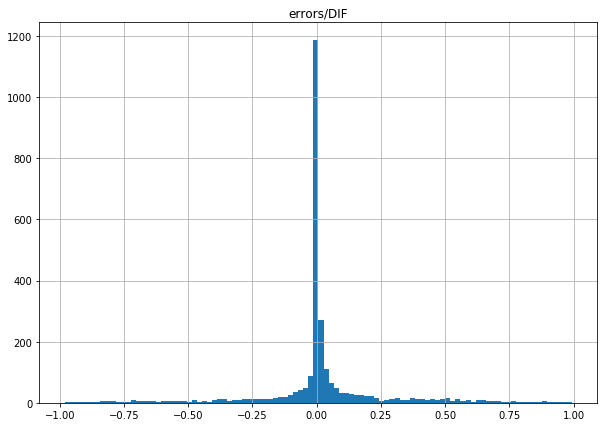

In [694]:
print(ms)
thresh = 0.5
for i in range(len(ms)):
    print('%s better %s' % (ms[i], ms[::-1][i]))
    print(len(df_scores_data[(df_scores_data['errors/' + ms[i]] < thresh) & (df_scores_data['errors/' + ms[::-1][i]] > thresh)]))
    #print(len(df_scores_data_sorted[df_scores_data_sorted['errors/DIF'] > 0.25]))
print(len(df_scores_data))
#len(df_scores_data[df_scores_data['has_passive']])
#df_scores_data_sorted.boxplot(by=['has_passive'], column='errors/DIF', figsize=figsize)
#print(df_scores_data[df_scores_data['has_passive']]['errors/DIF'].mean())
#print(df_scores_data[~df_scores_data['has_passive']]['errors/DIF'].mean())
#print(st.ttest_ind(df_scores_data[df_scores_data['has_passive']]['errors/DIF'],df_scores_data[~df_scores_data['has_passive']]['errors/DIF']))
df_scores_data.hist(column='errors/DIF', bins=100, figsize=(10,7))

In [657]:
# best 20 RECNN
df_scores_data_sorted = df_scores_data.sort_values(by='errors/DIF')
df_scores_data_sorted[-20:]

,scores_gold,errors/DIF,errors/TREE:X:GRU:BD-IS-LCA,errors/TREE:X:GRU:BD-LCA,scores_predicted/TREE:X:GRU:BD-IS-LCA,scores_predicted/TREE:X:GRU:BD-LCA,depth,length,tokens,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut
1556,1.0,0.932422,0.013856,0.946277,0.986144,0.053723,10,28,"[(A, det), (plasma, nsubjpass), (was, auxpass), (generated, ROOT), (by, case), (an, det), (electric, amod), (discharge, nmod), (between, case), (electrodes, nmod), (located, acl), (in, case), (the, det), (focal, amod), (plane, nmod), (of, case), (the, det), (lens, nmod), (and, cc), (separated, conj), (by, case), (~, compound), (1, nummod), (cm, nmod), (from, case), (one, nmod), (another, dep), (., punct)]",0.357143,280,38,28,10
305,1.0,0.941212,0.001163,0.942375,0.998837,0.057625,11,26,"[(I, nsubj), (read, ROOT), (the, det), (report, dobj), (from, case), (Somalia, nmod), (on, case), (the, det), (agreement, nmod), (reached, acl), (by, case), (faction, compound), (leaders, nmod), (on, case), (the, det), (form, nmod), (of, case), (a, det), (future, amod), (government, nmod), (that, nsubjpass), (has, aux), (been, auxpass), (warmly, advmod), (welcomed, acl:relcl), (., punct)]",0.423077,286,37,26,11
955,1.0,0.945659,0.011266,0.956925,0.988734,0.043075,7,13,"[(The, det), (law-maker, nsubj), (narrowly, advmod), (escaped, ROOT), (by, mark), (fleeing, advcl), (from, case), (his, nmod:poss), (house, nmod), (on, case), (a, det), (horse, nmod), (., punct)]",0.538462,91,20,13,7
1715,1.0,0.950911,0.041004,0.991915,0.958996,0.008085,7,11,"[(The, det), (patient, nsubjpass), (has, aux), (been, auxpass), (placed, ROOT), (into, case), (a, det), (drug, nmod), (induced, amod), (coma, dep), (., punct)]",0.636364,77,18,11,7
1216,1.0,0.953792,0.044190,0.997982,0.955810,0.002018,8,18,"[(A, det), (man, nsubj), (relaxes, ROOT), (with, case), (higher, amod), (levels, nmod), (of, case), (testosterone, nmod), (,, punct), (and, cc), (a, det), (woman, nsubj), (relaxes, conj), (by, case), (secretion, nmod), (of, case), (oxytocin, nmod), (., punct)]",0.444444,144,26,18,8
1925,1.0,0.953837,0.036348,0.990185,0.963652,0.009815,9,37,"[(To, mark), (heighten, advcl), (that, det), (translucent, amod), (effect, dobj), (,, punct), (the, det), (executive, compound), (offices, nsubjpass), (have, aux), (been, auxpass), (placed, ROOT), (in, case), (the, det), (middle, nmod), (of, case), (the, det), (building, nmod), (,, punct), (while, mark), (underlings, nsubj), (,, punct), (with, case), (their, nmod:poss), (open-plan, amod), (work, compound), (stations, nmod), (,, punct), (get, advcl), (to, mark), (enjoy, xcomp), (breathtaking, amod), (views, dobj), (over, case), (the, det), (Hudson, nmod), (., punct)]",0.243243,333,46,37,9
1485,1.0,0.957744,0.021282,0.979026,0.978718,0.020974,9,15,"[(The, det), (prince, nsubj), (decorated, ROOT), (the, det), (cake, dobj), (with, case), (a, det), (frosting, nmod), (I, nsubj), (pre-made, acl:relcl), (from, case), (confectioner, nmod:poss), ('s, case), (sugar, nmod), (., punct)]",0.600000,135,24,15,9
1529,1.0,0.960247,0.031765,0.992013,0.968235,0.007987,9,22,"[(Thus, advmod), (,, punct), (the, det), (princess, nsubjpass), (was, auxpass), (born, ROOT), (in, case), (the, det), (midst, nmod), (of, case), (the, det), (storm, nmod), (that, nsubj), (swept, acl:relcl), (over, case), (the, det), (world, nmod), (in, case), (March, nmod), (,, punct), (1848, amod), (., punct)]",0.409091,198,31,22,9
1344,1.0,0.966336,0.010156,0.976491,0.989844,0.023509,9,19,"[(The, det), (crisis, nsubj), (originated, ROOT), (in, case), (an, det), (over-leveraged, amod), (corporate, amod), (sector, nmod), (and, cc), (a, det), (banking, compound), (sector, conj), (that, nsubj), (had, aux), (mismatched, acl:relcl), (assets, dobj), (and, cc), (liabilities, conj), (., punct)]",0.473684,171,28,19,9
1867,1.0,0.972634,0.000222,0.972855,0.999778,0.027145,10,42,"[(Those, nsubj), (of, case), (us, nmod), (resolving, csubj), (to, mark), (lead, xcomp), (a, det), (lower-carbon, am

In [658]:
# best 20 COMPETITOR
df_scores_data_sorted = df_scores_data.sort_values(by='errors/DIF')
df_scores_data_sorted[:20]

,scores_gold,errors/DIF,errors/TREE:X:GRU:BD-IS-LCA,errors/TREE:X:GRU:BD-LCA,scores_predicted/TREE:X:GRU:BD-IS-LCA,scores_predicted/TREE:X:GRU:BD-LCA,depth,length,tokens,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut
1573,1.0,-0.992393,0.992736,0.000343,0.007264,0.999657,10,26,"[(The, det), (cause, nsubj), (for, case), (the, det), (jump, nmod), (to, case), (over, case), (30,000, nmod), (was, cop), (the, det), (deterioration, ROOT), (in, case), (the, det), (economy, nmod), (triggered, acl), (by, case), (a, det), (series, nmod), (of, case), (bankruptcies, nmod), (among, case), (banks, nmod), (and, cc), (securities, compound), (firms, conj), (., punct)]",0.384615,260,36,26,10
2202,1.0,-0.990882,0.999984,0.009102,0.000016,0.990898,10,19,"[(A, det), (computer, compound), (program, ROOT), (called, acl), (Trakl, dep), (`, punct), (Bigi, nsubj), (generates, xcomp), (poems, dobj), (in, case), (the, det), (style, nmod), (of, case), (the, det), (expressionist, compound), (poet, compound), (Georg, compound), (Trakl, nmod), (., punct)]",0.526316,190,29,19,10
27,1.0,-0.967464,0.997434,0.029970,0.002566,0.970030,8,24,"[(He, nsubj), (has, aux), (built, ROOT), (a, det), (formidable, amod), (reputation, dobj), (writing, acl), (powerful, amod), (dramas, dobj), (for, case), (the, det), (stage, nmod), (and, cc), (screen, conj), (,, punct), (based, case), (on, case), (real, amod), (events, nmod), (or, cc), (socially, advmod), (vital, amod), (issues, conj), (., punct)]",0.333333,192,32,24,8
1198,1.0,-0.964944,0.967192,0.002247,0.032808,0.997753,7,11,"[(The, det), (Busha, compound), (cattle, nsubj), (is, cop), (a, det), (breed, ROOT), (originated, acl), (in, case), (middle, amod), (ages, nmod), (., punct)]",0.636364,77,18,11,7
2668,1.0,-0.963284,0.966566,0.003282,0.033434,0.996718,8,20,"[(The, det), (book, nsubj), (has, aux), (made, ROOT), (a, det), (significant, amod), (contribution, dobj), (to, case), (the, det), (study, nmod), (of, case), (fashion, compound), (buying, nmod), (and, cc), (merchandising, conj), (in, case), (a, det), (UK, compound), (context, nmod), (., punct)]",0.400000,160,28,20,8
1187,1.0,-0.960276,0.999873,0.039597,0.000127,0.960403,7,14,"[(A, det), (controversy, nsubj), (arose, ROOT), (from, case), (an, det), (equivocal, amod), (assignment, nmod), (of, case), (the, det), (metastable, amod), (UNKNOWN, compound), (vibrational, amod), (peak, nmod), (., punct)]",0.500000,98,21,14,7
2024,1.0,-0.956503,0.982186,0.025683,0.017814,0.974317,7,17,"[(Then, advmod), (the, det), (driver, nsubj), (turned, ROOT), (the, det), (car, dobj), (into, case), (a, det), (dark, amod), (and, cc), (narrow, conj), (street, nmod), (and, cc), (reduced, conj), (his, nmod:poss), (speed, dobj), (., punct)]",0.411765,119,24,17,7
700,1.0,-0.949187,0.993208,0.044021,0.006792,0.955979,9,16,"[(Picture, nsubj), (192, nummod), (shows, ROOT), (a, det), (completed, amod), (dowel, dobj), (with, case), (a, det), (small, amod), (groove, nmod), (running, acl), (along, case), (its, nmod:poss), (entire, amod), (length, nmod), (., punct)]",0.562500,144,25,16,9
683,1.0,-0.945651,0.995102,0.049450,0.004898,0.950550,8,18,"[(The, det), (UNKNOWN, compound), (fleet, nsubj), (anchored, csubj), (idle, xcomp), (off, case), (UNKNOWN, nmod), (is, cop), (an, det), (interesting, amod), (proxy, ROOT), (for, case), (the, det), (collapse, nmod), (in, case), (world, compound), (trade, nmod), (., punct)]",0.444444,144,26,18,8
2540,1.0,-0.940662,0.985373,0.044711,0.014627,0.955289,7,16,"[(The, det), (full, amod), (press, compound), (release, nsubjpass), (from, case), (the, det), (studio, nmod), (is, auxpass), (pasted, ROOT), (at, case), (the, det), (bottom, nmod), (of, case), (this, det), (post, nmod), (., punct)]",0.437500,112,23,16,7


In [667]:
#df_scores_data_sorted[(df_scores_data_sorted['length'] > 21) & (df_scores_data_sorted['depth'] > 6)]

def display_group_by_w_count(df, column):
    grouped = df.groupby(column)
    pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
    df_temp = pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index()
    # filter min count
    df_temp = df_temp[df_temp['count'] >= 1]
    display_colored(df_temp, columns=None) 
    pers = pearsonr(df_temp['errors/DIF'], df_temp[column])
    print('correlation for grouped by %s: pearson=%.4f\tp=%.4f' % (column, pers[0], pers[1]))
    #return df_temp
    #display(df.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0).apply(max_white, columns=columns, columns_inverted=columns_inverted, axis=0).format(lambda x: "{:.4f}".format(x) if isinstance(x,float) else x))

In [668]:
df_scores_data_filtered = df_scores_data
if task == 'RE/SEMEVAL2010T8':
    df_scores_data_filtered = df_scores_data_filtered[df_scores_data_filtered['length'] <= 50]
    print('discard %i of %i records' % (len(df_scores_data) - len(df_scores_data_filtered), len(df_scores_data)))
    #    df_scores_data_filtered = df_scores_data_filtered[(df_scores_data_filtered['length'] < 48) & (df_scores_data_filtered['length'] > 5) & (df_scores_data_filtered['depth'] < 15) & (df_scores_data_filtered['depth'] > 5)]
##    df_scores_data_filtered = df_scores_data_filtered[(df_scores_data_filtered['length'] < 42) & (df_scores_data_filtered['length'] > 5) & (df_scores_data_filtered['depth'] < 12) & (df_scores_data_filtered['depth'] > 5)]



# correlation of length and gain per depth level (RTE task)

rows = []
grouped = df_scores_data_filtered.groupby('depth')
for g_key in grouped.groups:
    current_group = grouped.get_group(g_key)
    #display(current_group)
    #break
    pers = pearsonr(current_group['errors/DIF'], current_group['length'])
    #rint(g_key, pers)
    if len(current_group) > 3:
        rows.append((g_key, len(current_group)) + pers)
display_colored(pd.DataFrame(rows, columns=['depth', 'count', 'pearson', 'p']), columns=None, columns_inverted=['p'])
    
    
    

discard 17 of 2715 records


/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,depth,count,pearson,p
0,6,388,0.0243,0.6337
1,7,676,0.0032,0.9336
2,8,684,-0.0378,0.3241
3,9,505,0.0254,0.5698
4,10,255,0.1585,0.0113
5,11,111,-0.0503,0.6003
6,12,35,0.0473,0.7873
7,13,26,0.0874,0.6711
8,14,12,-0.3264,0.3005


In [669]:
# depth_length_ratio = depth / length -> 0.6 = depth / length -> depth = 0.6 * length
#display(1.0 / df_scores_data['depth_length_ratio'])
rows = []
threshold = 0.5
for threshold in np.arange(0,1,0.05):
#for threshold in np.arange(1,10,0.5):
    _filter = df_scores_data['depth_length_ratio'] < threshold
    ttest = st.ttest_ind(df_scores_data[_filter]['errors/DIF'], df_scores_data[~_filter]['errors/DIF'])
    #print(ttest)
    rows.append((threshold,df_scores_data[_filter]['errors/DIF'].mean(),  df_scores_data[~_filter]['errors/DIF'].mean()) + ttest)
pd.DataFrame(rows, columns=['t', 'mean_below', 'mean_above', 'stat', 'p'])

/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,t,mean_below,mean_above,stat,p
0,0.00,NaN,0.024808,NaN,NaN
1,0.05,NaN,0.024808,NaN,NaN
2,0.10,NaN,0.024808,NaN,NaN
3,0.15,-0.000039,0.024817,NaN,NaN
4,0.20,-0.093171,0.025200,-1.314847,0.188672
5,0.25,0.075666,0.023600,1.514956,0.129900
6,0.30,0.032781,0.024038,0.478576,0.632279
7,0.35,0.029719,0.023520,0.485799,0.627149
8,0.40,0.030271,0.022175,0.732749,0.463775
9,0.45,0.026837,0.022936,0.376557,0.706532


In [670]:


# by MAX_LENGTH
#df_scores_data[df_scores_data['length_max'] >= 25]
#grouped = df_scores_data.groupby('length')
#pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
#display_colored(pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index(), columns=None)
display_group_by_w_count(df_scores_data_filtered, 'length')
#display_colored(df_scores_data.groupby('length').mean().reset_index(), columns=None)

#df_scores_data.groupby('length_max').mean().reset_index()

,length,scores_gold,errors/DIF,errors/TREE:X:GRU:BD-IS-LCA,errors/TREE:X:GRU:BD-LCA,scores_predicted/TREE:X:GRU:BD-IS-LCA,scores_predicted/TREE:X:GRU:BD-LCA,depth,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut,count
0,5,1.0000,0.0921,0.0029,0.0950,0.9971,0.9050,6.0000,1.2000,30.0000,11.0000,5.0000,6.0000,1
1,6,1.0000,0.0609,0.0653,0.1262,0.9347,0.8738,5.9231,0.9872,35.5385,11.9231,6.0000,5.9231,13
2,7,1.0000,-0.0009,0.2654,0.2645,0.7346,0.7355,6.0556,0.8651,42.3889,13.0556,7.0000,6.0556,36
3,8,1.0000,0.0257,0.1823,0.2079,0.8177,0.7921,6.0857,0.7607,48.6857,14.0857,8.0000,6.0857,70
4,9,1.0000,0.0386,0.1770,0.2156,0.8230,0.7844,6.2353,0.6928,56.1176,15.2353,9.0000,6.2353,102
5,10,1.0000,-0.0166,0.2298,0.2132,0.7702,0.7868,6.4495,0.6450,64.4954,16.4495,10.0000,6.4495,109
6,11,1.0000,0.0043,0.2487,0.2530,0.7513,0.7470,6.7445,0.6131,74.1898,17.7445,11.0000,6.7445,137
7,12,1.0000,0.0410,0.1980,0.2390,0.8020,0.7610,7.0662,0.5888,84.7941,19.0662,12.0000,7.0662,136
8,13,1.0000,0.0606,0.2489,0.3095,0.7511,0.6905,7.1849,0.5527,93.4041,20.1849,13.0000,7.1849,146
9,14,1.0000,0.0075,0.2125,0.2201,0.7875,0.7799,7.4863,0.5347,104.8082,21.4863,14.0000,7.4863,146


correlation for grouped by length: pearson=0.0604	p=0.6933


In [671]:
# by MAX_DEPTH
#df_scores_data[df_scores_data['length_max'] >= 25]
#grouped = df_scores_data.groupby('depth')
#pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
#display_colored(pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index(), columns=None)
display_group_by_w_count(df_scores_data_filtered, 'depth')
#df_scores_data.groupby('length_max').mean().reset_index()

#df_scores_data.boxplot(by='depth', column='errors/DIF')

,depth,scores_gold,errors/DIF,errors/TREE:X:GRU:BD-IS-LCA,errors/TREE:X:GRU:BD-LCA,scores_predicted/TREE:X:GRU:BD-IS-LCA,scores_predicted/TREE:X:GRU:BD-LCA,length,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut,count
0,5,1.0000,0.0076,0.3704,0.3780,0.6296,0.6220,10.0000,0.5952,50.0000,15.0000,10.0000,5.0000,2
1,6,1.0000,0.0182,0.1902,0.2084,0.8098,0.7916,9.9072,0.6376,59.4433,15.9072,9.9072,6.0000,388
2,7,1.0000,0.0236,0.2416,0.2652,0.7584,0.7348,15.0725,0.4990,105.5074,22.0725,15.0725,7.0000,676
3,8,1.0000,0.0250,0.2616,0.2865,0.7384,0.7135,19.5219,0.4421,156.1754,27.5219,19.5219,8.0000,684
4,9,1.0000,0.0417,0.2474,0.2891,0.7526,0.7109,22.6198,0.4269,203.5782,31.6198,22.6198,9.0000,505
5,10,1.0000,-0.0007,0.2554,0.2547,0.7446,0.7453,25.1608,0.4212,251.6078,35.1608,25.1608,10.0000,255
6,11,1.0000,0.0297,0.2698,0.2995,0.7302,0.7005,28.7748,0.4068,316.5225,39.7748,28.7748,11.0000,111
7,12,1.0000,0.0598,0.1354,0.1952,0.8646,0.8048,28.6857,0.4509,344.2286,40.6857,28.6857,12.0000,35
8,13,1.0000,-0.0075,0.2076,0.2001,0.7924,0.7999,34.3846,0.4024,447.0000,47.3846,34.3846,13.0000,26
9,14,1.0000,0.0787,0.0964,0.1751,0.9036,0.8249,35.7500,0.4107,500.5000,49.7500,35.7500,14.0000,12


correlation for grouped by depth: pearson=0.4993	p=0.0824


In [672]:
#grouped = df_scores_data.groupby(['length', 'depth'])
#pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
#display_colored(pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index(), columns=None)
grouped_depth = df_scores_data_filtered.groupby('depth').mean().reset_index()
pers = pearsonr(grouped_depth['errors/DIF'], grouped_depth['depth'])
pers

(0.4992545908053242, 0.08239379791441623)

min_group_count: 3
counts_sum_all:	2698
counts_sum_dropped:	120
counts_sum_remaining:	2578
finished /mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp/re_length_depth


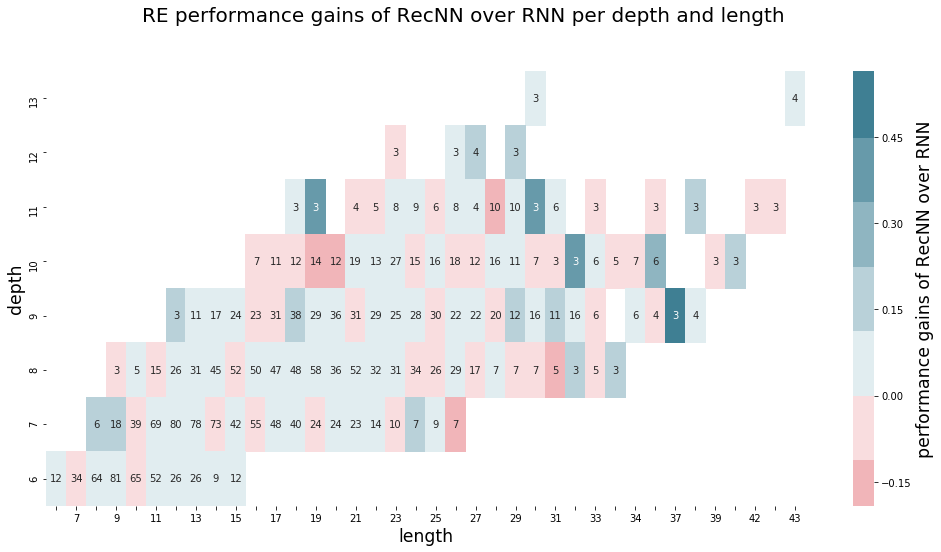

In [673]:
_filter = [True] * len(df_scores_data_filtered)
#_filter = (df_scores_data['depth'] <= 8) 
grouped = df_scores_data_filtered[_filter].groupby(['depth', 'length'])['errors/DIF']
#df_length_depth = df_scores_data.groupby(['depth', 'length'])['errors/DIF'].mean().unstack('length').sort_index(ascending=False)
#df_length_depth_count = df_scores_data_filtered.groupby(['depth', 'length'])['errors/DIF'].count()
grouped_mean = grouped.mean()
grouped_count = grouped.count()
#display(grouped_count)

if task == 'SENTIMENT/IMDB':
    min_group_count = 25
    figsize=(20,10)
else:
    min_group_count = 3
    figsize=(17,8)
print('min_group_count: %i' % min_group_count)
_filter = (grouped_count < min_group_count)

#display(grouped_count)
counts_sum_all = grouped_count.sum()
print('counts_sum_all:\t%i' % counts_sum_all)
grouped_mean.drop(grouped_mean[_filter].index, inplace=True)
grouped_count.drop(grouped_count[_filter].index, inplace=True)
counts_sum_dropped = counts_sum_all - grouped_count.sum()
print('counts_sum_dropped:\t%i' % counts_sum_dropped)
print('counts_sum_remaining:\t%i' % grouped_count.sum())
#grouped_mean[_filter] = np.nan
#grouped_mean = grouped_mean.dropna(how='all')
#grouped_count[_filter] = np.nan
#display(grouped_count)
#grouped_count = grouped_count.dropna(how='all')


#display(grouped_mean)
df_length_depth = grouped_mean.unstack('length').sort_index(ascending=False)
#display(df_length_depth)
df_length_depth_count = grouped_count.unstack('length').sort_index(ascending=False).astype('Int64')
#display(df_length_depth_count)

#display(df_length_depth_count)
#.filter(lambda x: x['B'].mean() > 3.)


#df_length_depth
#uniform_data = np.random.rand(10, 12)
fig, ax = plt.subplots(figsize=figsize)
cmap = sns.color_palette("coolwarm", 10)
#cmap = sns.color_palette("RdBu_r", 7)
cmap = sns.diverging_palette(10, 220, sep=10, n=10)
#annot = None
annot = df_length_depth_count.values
#annot[annot >= 10] = 'x'
sns.heatmap(df_length_depth, annot=annot, ax=ax, cmap=cmap, fmt='', center=0.0, cbar_kws={'label': 'performance gains of RecNN over RNN'})
ax.set_title('RE performance gains of RecNN over RNN per depth and length', y=1.1, x=0.55, fontsize=20)#'xx-large')
ax.xaxis.label.set_fontsize('xx-large')
ax.yaxis.label.set_fontsize('xx-large')
# resize colorbor label 
fig.axes[-1].yaxis.label.set_size('xx-large')
# disable every second tick
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

#df_length_depth
images = {}
images['re_length_depth'] = fig
print_images(images=images, path=image_path)

In [674]:
print(task)
# 2-sentence tasks:
# RELATEDNESS
# structural differences have impact on performance for both models:
#   RNN: depnds on lengt and not on depth (just weakly significant)
#   TREE: depends on depth, but not on length 
# TREE still preforms better on higher depth-differences 

#df_scores_data_sorted_filtered = 

def check_correlation(df):
    rows = []
    rows_grouped = []
    group_cols = ['depth', 'length', 'overlap_gold_dif']
    for col in ['depth', 'length', 'scores_gold', 'overlap_gold_dif', 'depth_length_ratio', 'depth_length_product', 'depth_length_sum', 'length_cut', 'depth_cut']:
        for suffix in ['_difabs', '']:
            _d = col + suffix
            if _d in group_cols and _d in df:
                grouped = df.groupby(_d)
            else:
                grouped = None

            if _d in df:
                #print(_d)
                for m in ms + ['DIF']:
                    #print('%s\t%s' % (_d, 'errors/' + m))
                    pers = pearsonr(df['errors/' + m], df[_d])
                    #print(pers)
                    rows.append(('errors/' + m, _d) + pers)
                    if grouped is not None:
                        grouped_mean = grouped.mean().reset_index()
                        #print(m)
                        #print(grouped_mean['errors/' + m])
                        #print(grouped_mean[_d])
                        pers_grouped = pearsonr(grouped_mean['errors/' + m], grouped_mean[_d])
                        rows_grouped.append(('errors/' + m, _d) + pers_grouped + (len(grouped), ))#str(list(grouped.groups)) if len(grouped.groups) < 30 else '...'))
    #pd.DataFrame(rows, columns=('m', 'd' , 'corr', 'p_value')).set_index(['m', 'd'])
    display_colored(pd.DataFrame(rows, columns=('m', 'd' , 'corr', 'p_value')).set_index(['m', 'd']), columns=None, columns_inverted=['p_value'])
    #pd.DataFrame(rows_grouped, columns=('m', 'd' , 'corr', 'p_value', 'count')).set_index(['m', 'd'])
    display_colored(pd.DataFrame(rows_grouped, columns=('m', 'd' , 'corr', 'p_value', 'count')).set_index(['m', 'd']), columns=None, columns_inverted=['p_value'])
    
#check_correlation(df_scores_data_filtered[(df_scores_data_filtered['length'] <= 500) & (df_scores_data_filtered['depth'] <= 50)])
check_correlation(df_scores_data_filtered)

RE/SEMEVAL2010T8


/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


,,corr,p_value
m,d,,
errors/TREE:X:GRU:BD-IS-LCA,depth,0.0136,0.4816
errors/TREE:X:GRU:BD-LCA,depth,0.0197,0.3056
errors/DIF,depth,0.0088,0.6477
errors/TREE:X:GRU:BD-IS-LCA,length,0.0039,0.8388
errors/TREE:X:GRU:BD-LCA,length,0.0155,0.4224
errors/DIF,length,0.0162,0.3990
errors/TREE:X:GRU:BD-IS-LCA,scores_gold,nan,1.0000
errors/TREE:X:GRU:BD-LCA,scores_gold,nan,1.0000
errors/DIF,scores_gold,nan,1.0000


,,corr,p_value,count
m,d,,,
errors/TREE:X:GRU:BD-IS-LCA,depth,-0.8551,0.0002,13
errors/TREE:X:GRU:BD-LCA,depth,-0.5062,0.0776,13
errors/DIF,depth,0.4993,0.0824,13
errors/TREE:X:GRU:BD-IS-LCA,length,0.1203,0.4312,45
errors/TREE:X:GRU:BD-LCA,length,0.1309,0.3914,45
errors/DIF,length,0.0604,0.6933,45


finished /mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp/re_length_depth
finished /mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp/imdb_length_depth


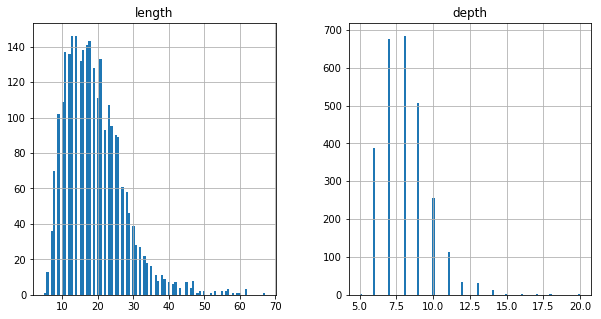

In [717]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
df_scores_data_sorted[df_scores_data_sorted['length'] <= 500].hist(column='length', bins=100, ax=axes[0], label='length')
df_scores_data_sorted[df_scores_data_sorted['depth'] <= 50].hist(column='depth', bins=100, ax=axes[1], label='depth')
#ax.yaxis.label.set_text('length')
#ax.yaxis.label.set_fontsize('x-large')
images['imdb_length_depth'] = fig
print_images(images=images, path=image_path)

In [591]:


#df_scores_data_sorted[df_scores_data_sorted['length'] > 500]['errors/DIF'].mean()
filter_col = {'FLAT:-:GRU': 'length', 'TREE:MAX:GRU': 'depth'}
filter_val = {'length': 500, 'depth': 50}
rows = []
filtered_errors = {}
for cut in [True, False]:
    for m in ms:
        _filter = df_scores_data_sorted[filter_col[m]] <= filter_val[filter_col[m]]

        if cut:
            _filter = ~_filter
        _df_filtered = df_scores_data_sorted[_filter]['errors/' + m]
        filtered_errors[(m, cut)] = _df_filtered
        _mean = _df_filtered.mean()
        rows.append((m, cut, _mean, 1.0 -_mean, len(_df_filtered)))
display(pd.DataFrame(rows, columns=('model','cut', 'errors', 'acc', 'nbr')).set_index(keys=['model','cut']))

print(st.ttest_ind(filtered_errors[('TREE:MAX:GRU', False)], filtered_errors[('FLAT:-:GRU', False)]))
print(st.ttest_ind(filtered_errors[('TREE:MAX:GRU', True)], filtered_errors[('FLAT:-:GRU', False)]))
print(st.ttest_ind(filtered_errors[('TREE:MAX:GRU', True)], filtered_errors[('FLAT:-:GRU', True)]))
print(st.ttest_ind(1.0-df_scores_data_sorted['errors/TREE:MAX:GRU'], 1.0-df_scores_data_sorted['errors/FLAT:-:GRU']))
print((1.0-df_scores_data_sorted['errors/TREE:MAX:GRU']).mean())
print((1.0-df_scores_data_sorted['errors/FLAT:-:GRU']).mean())

,,errors,acc,nbr
model,cut,,,
TREE:MAX:GRU,True,NaN,NaN,0
FLAT:-:GRU,True,NaN,NaN,0
TREE:MAX:GRU,False,0.225414,0.774586,2715
FLAT:-:GRU,False,0.234622,0.765378,2715


Ttest_indResult(statistic=-0.8060548879240542, pvalue=0.4202465127928353)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=0.8060548879240639, pvalue=0.42024651279283)
0.7745856353591161
0.7653775322283609


In [539]:
print((0.920716 - 0.912198) /  0.912198)
print((0.907550 - 0.912198) / 0.912198)
print((0.912198 - 0.907550) /  0.907550)
print((0.912198 - 0.897982) / 0.912198)

0.00933788497673
-0.00509538499317
0.00512148091014
0.0155843358569


In [540]:
391 / 25000.0

0.01564

In [541]:
for m in ms:
    print(m)
    print(df_scores_data_sorted[df_scores_data_sorted['length'] <= 500]['errors/' + m].mean())

TREE:MAX:GRU
0.225414364640884
FLAT:-:GRU
0.23462246777163903


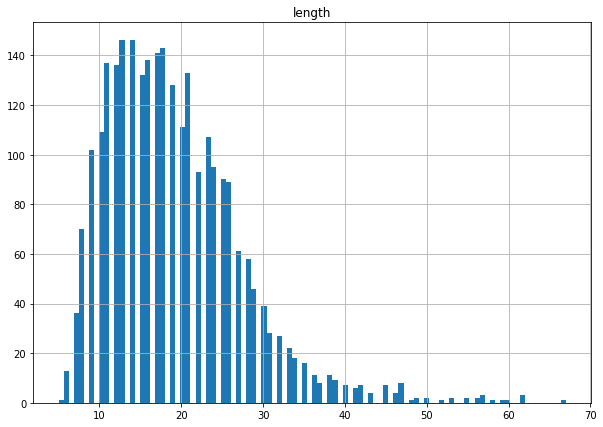

In [542]:
ax = df_scores_data_sorted[df_scores_data_sorted['length'] <= 500].hist(column='length', figsize=(10, 7), bins=100)

In [260]:
ax = df_scores_data_sorted.boxplot(by=['length_difabs'], column=['errors/DIF'], figsize=(15,10))

KeyError: 'length_difabs'

In [261]:
ax = df_scores_data_sorted.boxplot(by=['depth_difabs'], column=['errors/DIF'], figsize=(15,10))

KeyError: 'depth_difabs'

In [ ]:
#df_scores = pd.DataFrame([_scores_gold, _scores_predicted, np.abs(_scores_gold - _scores_predicted), _tokens, _lengths, _depths], index=['scores_gold', 'scores_predicted', 'errors', 'tokens', 'length', 'depth']).T
#df_scores['errors'] = np.abs(_scores_gold - _scores_predicted)
#df_data_stats[:5]

#df_scores_data_sorted[:100]
#df_scores_data_sorted[:20].hist(column='depth_max', bins=100, figsize=(20,5))
# random correlation:
#print(pearsonr(np.random.uniform(-1,0,1000), np.random.uniform(-1,0,1000)))
col = 'length_max'
#col_b = ('errors', 'DIF')
cols_b = ['errors/FLAT:-:GRU', 'errors/TREE:MAX:GRU']
col_b = 'errors/DIF'
#print(pearsonr(df_scores_data_sorted[col_b], df_scores_data_sorted[col]))
#ax = df_scores_data_sorted.plot.scatter(x=col, y=cols_b[0], figsize=(15,10), c='r')
#ax = df_scores_data_sorted.plot.scatter(x=col, y=cols_b[1], figsize=(15,10), c='g', ax=ax)
#ax = df_scores_data_sorted[cols_b + [col]].boxplot(by=col, figsize=(20,10))
#ax = df_scores_data_sorted[[cols_b[1], col]].boxplot(by=col, figsize=(15,10), ax=ax)
ax = df_scores_data_sorted.boxplot(by=['depth', 'length'], column=['errors/DIF'], figsize=(40,10))
format_xticks(ax, label_part_types=('pass', 'pass'))

In [220]:
#df_scores_data_sorted[-100:]
#df_scores_data_sorted[-20:].hist(column='depth_max', bins=100, figsize=(20,5))
#df_scores_data_sorted.plot.scatter(x='length_max', y=('errors', 'DIF'), figsize=(15,10))
ax = df_scores_data_sorted.boxplot(by='depth_max', column=['errors/DIF'], figsize=(20,10))

KeyError: 'depth_max'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f0eefdb10>]],
      dtype=object)

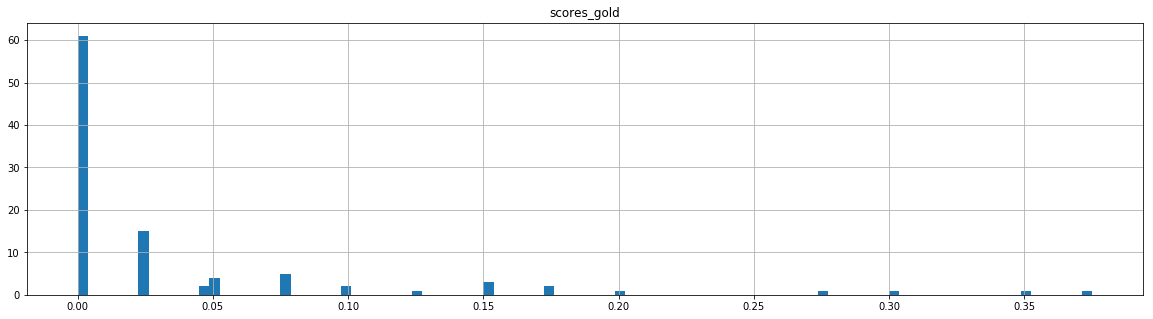

In [214]:
df_scores_data[-100:].hist(column='scores_gold', bins=100, figsize=(20,5))

# STOP

In [207]:
#print([v.replace(',', '\n') for v in cvs[p]])
#print({m: best_settings[m] for m in metrics[:2]})
#print(parameter_values_all)

df_plot = pd.DataFrame({m: best_settings[m][m].values for m in metrics[:2]}, index=[v.replace(':', '\n') for v in parameter_values_all]).sort_values(by=metrics[0]) #.sort_index() # 
#axes = df_plot.plot.bar(rot=0, subplots=True, figsize=(20, 10))
axes = df_plot.plot.bar(rot=0, secondary_y=metrics[1], figsize=(20, 10))
plt.title(map_task_long[task])#, y=y_suptitle)
#for m in metrics:
#    axes = df_plot.plot.bar(rot=0, y=m, figsize=(20, 5))
#axes[1].legend(loc=2) 

NameError: global name 'best_settings' is not defined

In [333]:
#cols_group = ['l', 'm']
#df_all[metrics_all + cols_group].groupby(cols_group).mean()
res = df_all[metrics + parameters + [COLUMN_RUN, COLUMN_DFIDX]].set_index(parameters)
res[:100]

KeyError: "['m'] not in index"

In [ ]:
from sklearn.utils import resample
def bootstrap_5th_percentile(data, n_bootstraps):
    bootstraps = []
    for _ in xrange(n_bootstraps):
        # Sample with replacement from data
        samples = resample(data)
        # Then we take the fifth percentile!
        bootstraps.append(np.percentile(samples, len(data) * 0.1))
    return pd.Series(bootstraps)
#values = res.xs(('NO', 'NO'))['pearson']
#bootstraps = bootstrap_5th_percentile(values, 10000)
#bootstraps.hist()

In [ ]:
#df_all.boxplot(by=parameters, column=metrics_performance, figsize=(40,20), notch=True)

In [ ]:
#for m in metrics_resources:
#    df_all.boxplot(by=parameters, column=m, figsize=(10,5))

In [ ]:
res.groupby(parameters).mean()

In [ ]:
#current_values = {'l': ['D', 'E'], 'm': ['SUM', 'MAX', 'GRU', 'SUM-GRU', 'MAX-GRU']}
#current_values = {p: list(set(df_all[p])) for p in parameters}
#current_values

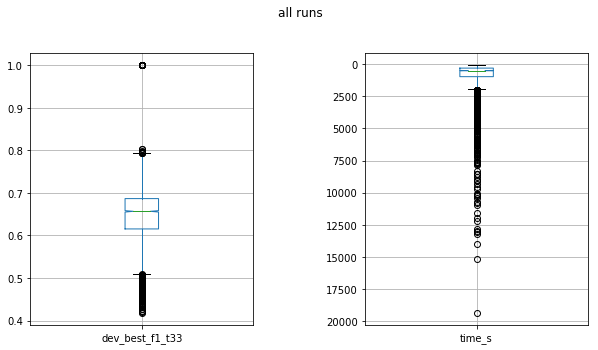

In [71]:
from matplotlib import rcParams
# final
#figsize = (4.5, 3)
# debug
figsize = (10, 5)


current_metrics = metrics



#rcParams['axes.titlepad'] = 20 
#rcParams['axes.titlepad'] = 20 
images = {}
bootstrap=10000
#rcParams.update({'figure.autolayout': True})

fig_merged, axs = plt.subplots(1, len(current_metrics), figsize=figsize)
for i, m in enumerate(current_metrics):
    res.boxplot(column=m, figsize=(figsize[i] / len(current_metrics), figsize[1]), ax=axs[i], bootstrap=bootstrap, notch=True)
    if m in metrics_inverted:
        axs[i].invert_yaxis()

#axs[0].invert_yaxis()
#axs[0].minorticks_on()
#axs[0].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
#res.boxplot(column='test_pearson_r', figsize=(figsize[0] / 2, figsize[1]), ax=axs[1], bootstrap=bootstrap, notch=True)
#axs[1].minorticks_on()
#axs[1].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
fig_merged.suptitle('all runs', y=1.01)
plt.subplots_adjust(wspace=0.5)
images['fig_merged'] = fig_merged

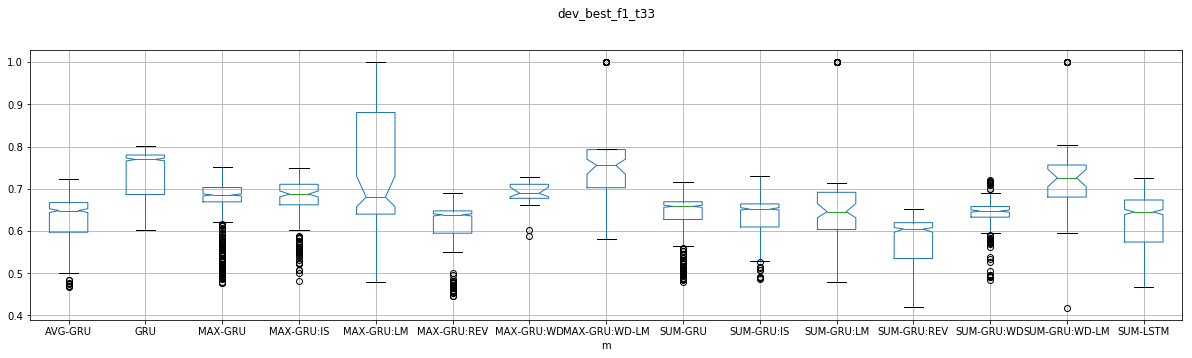

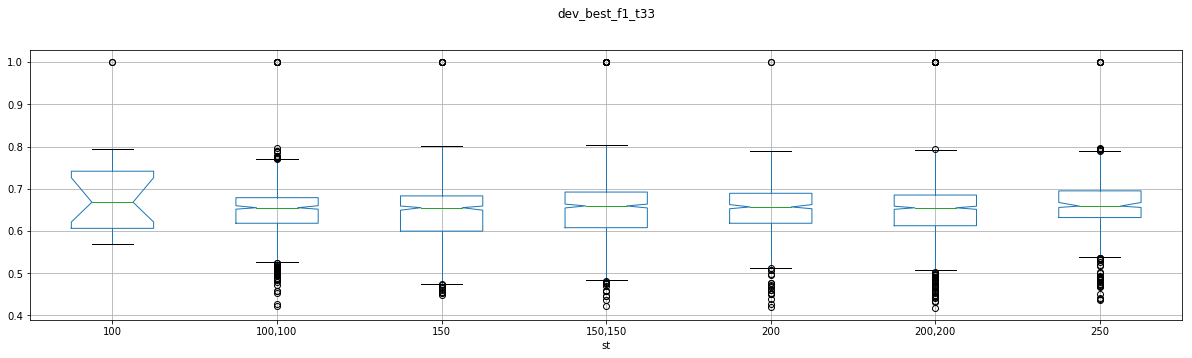

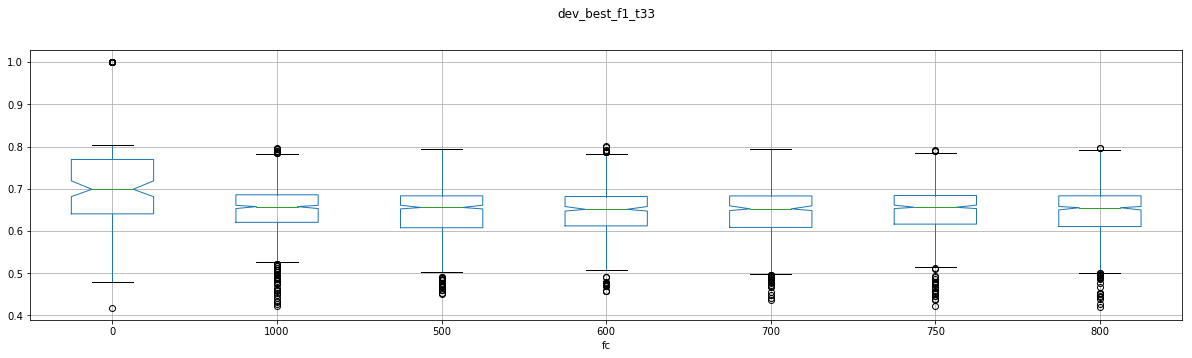

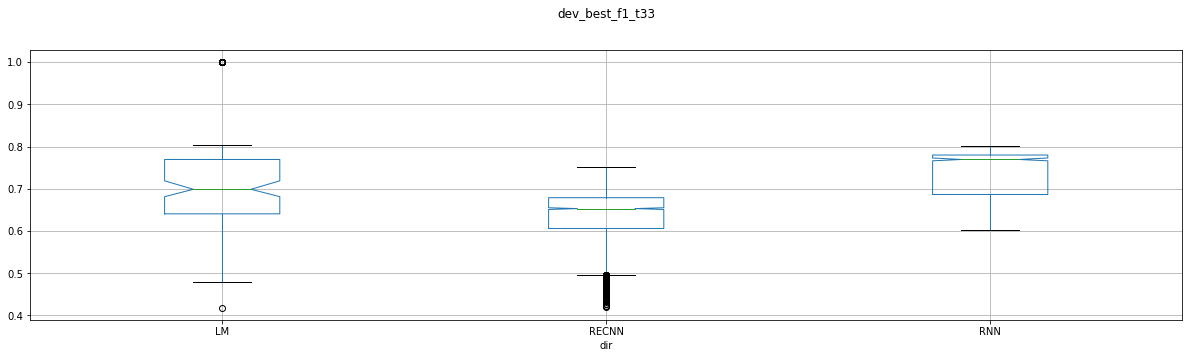

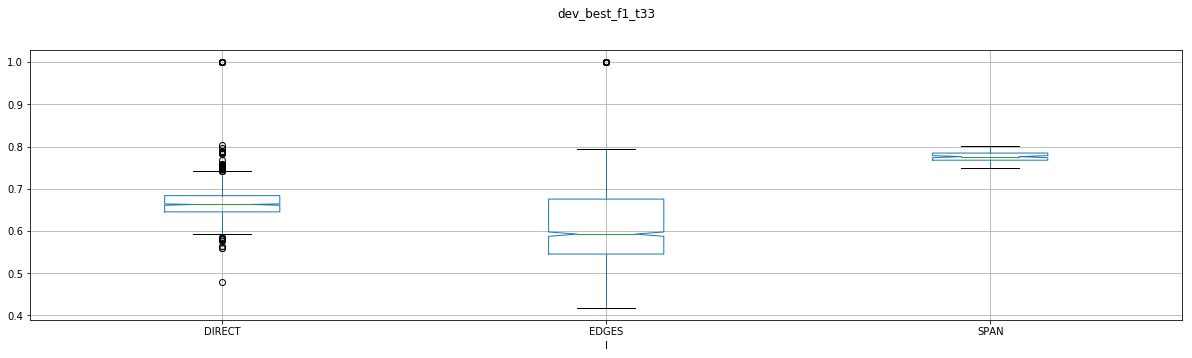

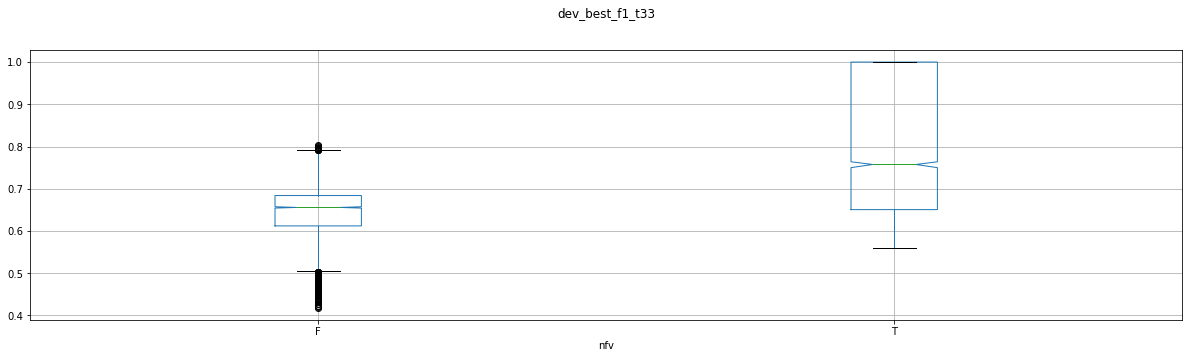

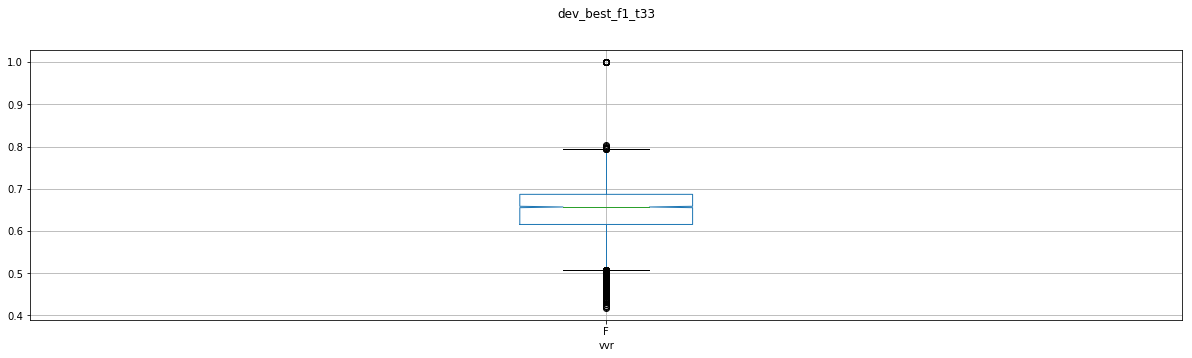

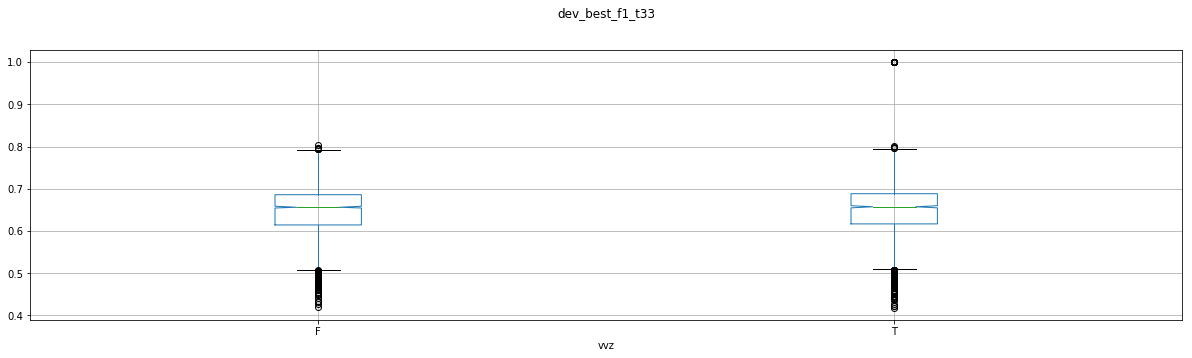

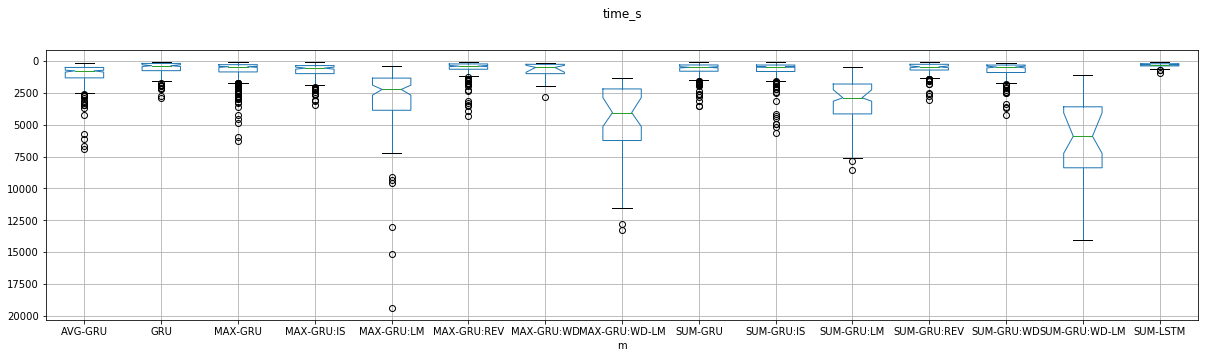

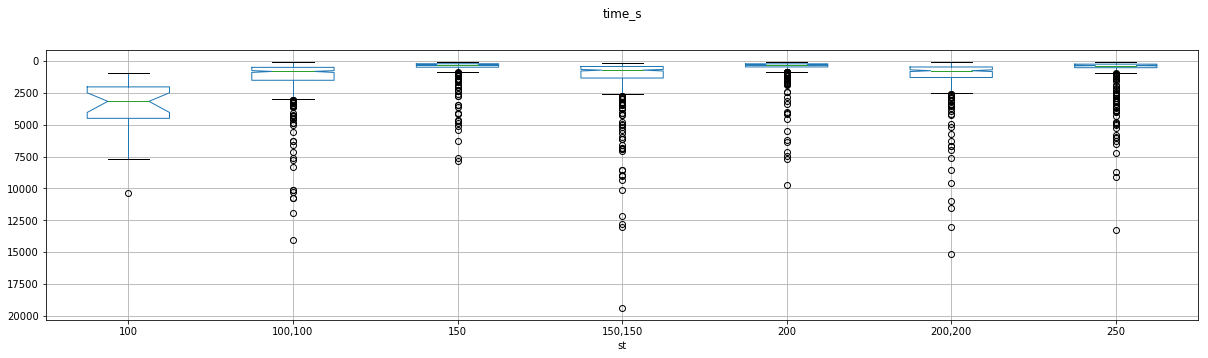

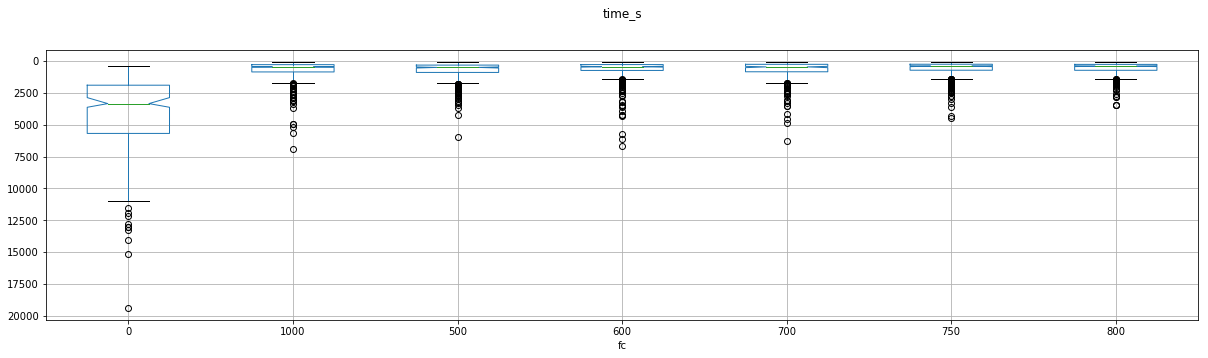

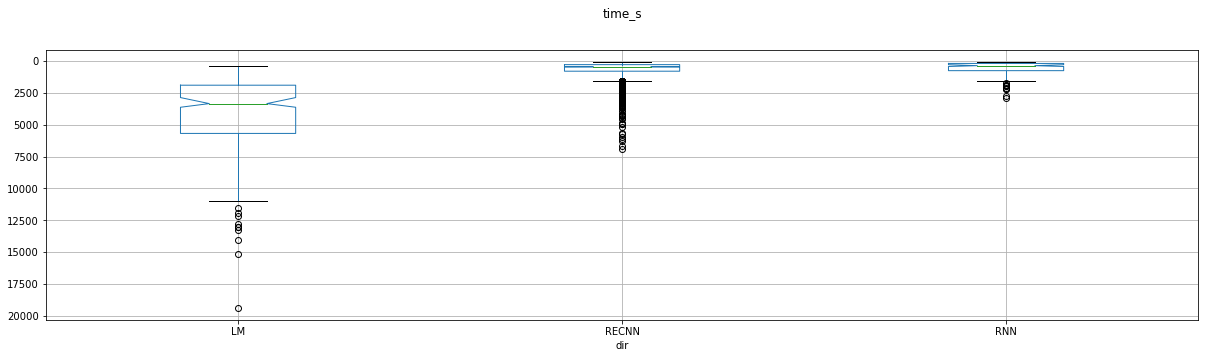

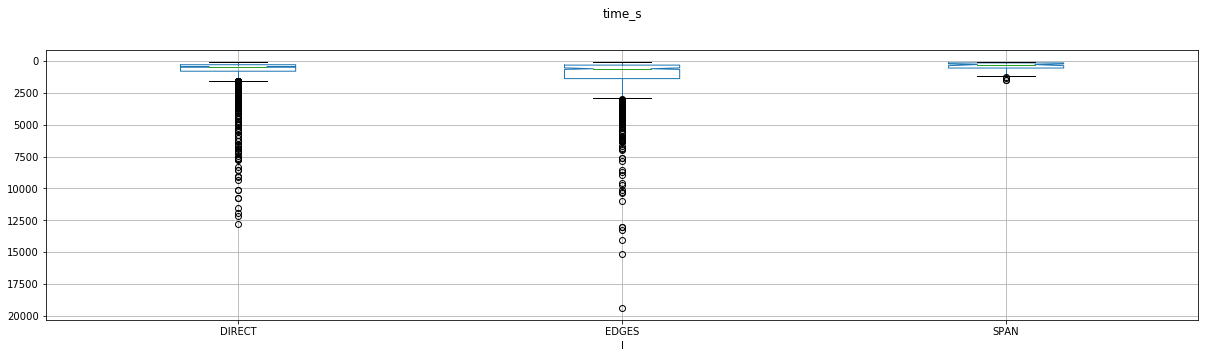

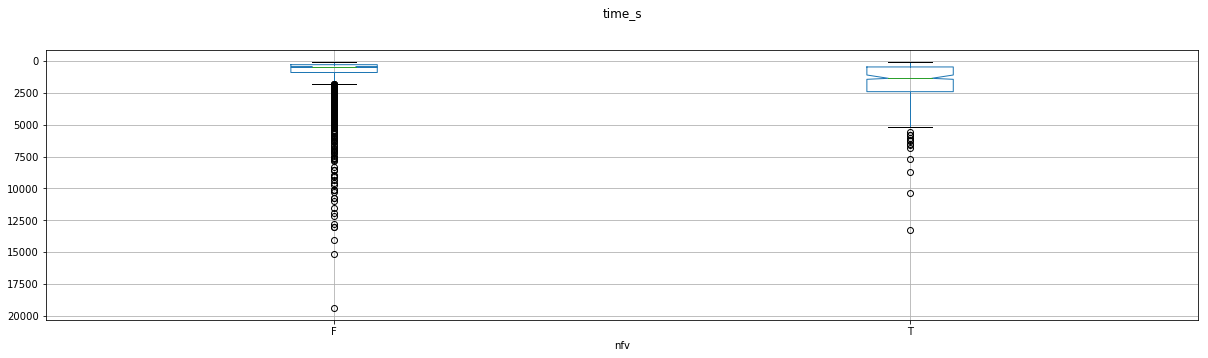

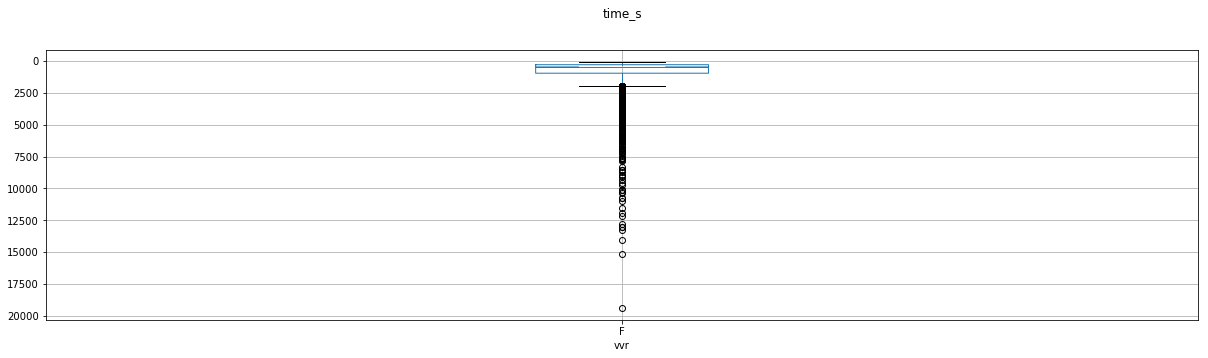

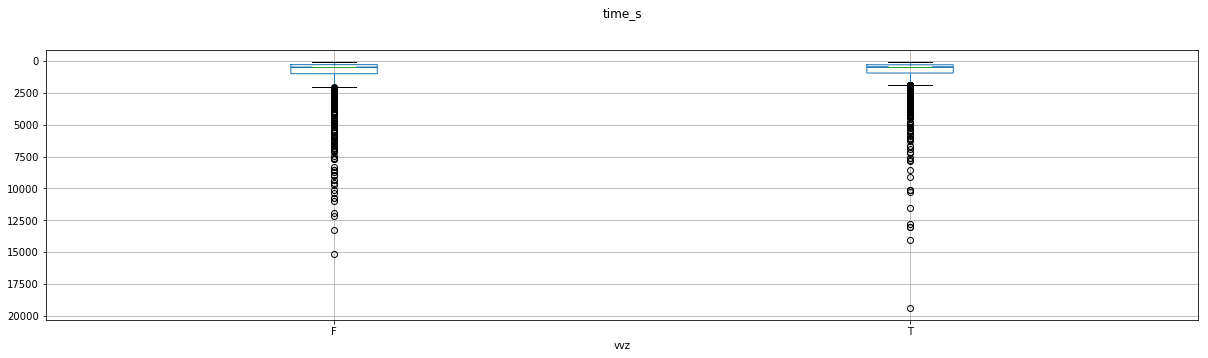

In [73]:
figsize = (20, 5)

y_title = 1.0
y_suptitle = 1.1

current_parameters = parameters[:2]
remaining_parameters = parameters[2:]
# use short versions

#levels = ['order aware', 'dependency available']
#other_level = {levels[0]: levels[1], levels[1]: levels[0]}
#other_parameter = {current_parameters[0]: current_parameters[1], current_parameters[1]:current_parameters[0]}

def param_long(param):
    #return ''.join([w[0].upper() for w in param.split()])
    return map_param_long.get(param, param)

#def boxplot_sorted(df, by, column, **kwargs):
#    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
#    meds = df2.median().sort_values()
#    return df2[meds.index].boxplot(rot=90, **kwargs)

current_values = get_current_values(df_all)

for m in current_metrics:
    for p in parameters:
        if len(current_values[p]) > 1:
            axs = res.boxplot(column=m, by=p, figsize=figsize, bootstrap=bootstrap, notch=True)
            if m in metrics_inverted:
                axs.invert_yaxis()
            #axs.minorticks_on()
            #axs.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
            plt.title(m, y=y_suptitle)
            fig_sep = axs.get_figure()
            fig_sep.suptitle('')
            images['fig_sep_'+m] = fig_sep




test_pearson_r
time_s


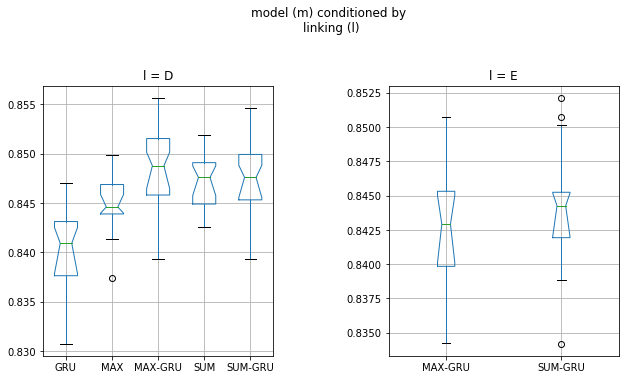

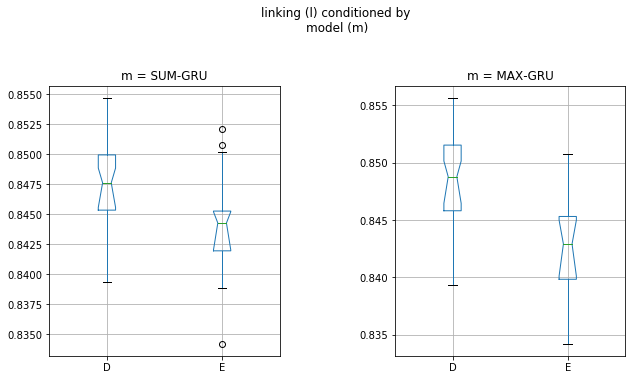

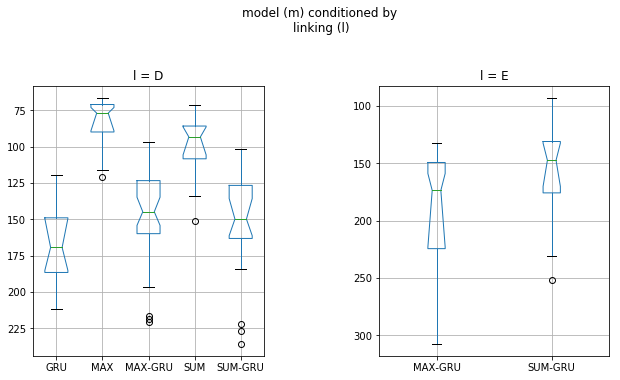

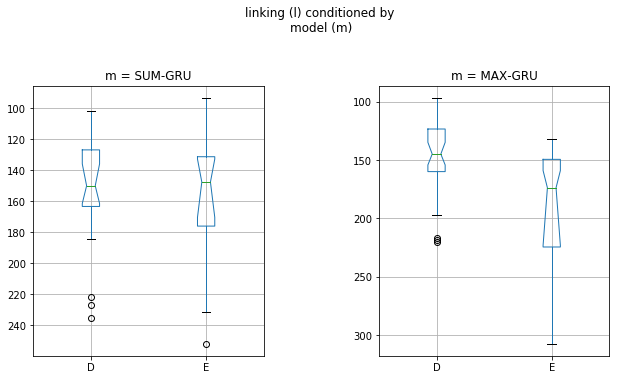

In [20]:
for m in current_metrics:
    print(m)
    for parameter in current_parameters:
        values = current_values[parameter]
        # collect values where other parameters has more then one values
        values_selected = []
        for i, v in enumerate(values):
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) > 1:
                values_selected.append(v)
        
        fig_sep, axs_sep = plt.subplots(1,len(values_selected), figsize=figsize)
        for i, v in enumerate(values_selected):

            #res.xs(v, level=parameter).boxplot(column=['pearson'], by=[other_parameter[parameter]], ax=axs_sep[0], bootstrap=bootstrap, notch=True)
            #axs_sep[0].set_title('pearson', y=y_title)
            #axs_sep[0].set_xlabel('')
            #print(res.xs(v, level=parameter)[m].groupby([other_parameter[parameter]]).count())
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) == 1:
                continue
            res.xs(v, level=parameter).boxplot(column=[m], by=[other_parameter[parameter]], ax=axs_sep[i], bootstrap=bootstrap, notch=True)
            axs_sep[i].set_title('%s = %s' % (parameter, v), y=y_title)
            axs_sep[i].set_xlabel('')
            if m in metrics_inverted:
                axs_sep[i].invert_yaxis()
        fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (param_long(other_parameter[parameter]), other_parameter[parameter], param_long(parameter), parameter), y=y_suptitle + 0.02)
        #fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (other_parameter[parameter], other_parameter[parameter], parameter, parameter), y=y_suptitle + 0.02)
        #plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
        plt.subplots_adjust(wspace=0.5)
        images['fig_sep_cond_%s' % other_parameter[parameter].split()[0]] = fig_sep


In [84]:
#import numpy
#from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
#from math import sqrt
#import scipy.stats as st

def bootstrap_convidence(values, n_iterations=1000, alpha=0.95):
    #values = res.xs(('NO', 'NO'))['pearson']
    mean_b = np.mean(values)
    std_b = np.std(values)
    n_b_root = sqrt(len(values))
    # configure bootstrap
    #n_iterations = 10000
    n_size = int(len(values) * 0.10)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        samples = resample(values, n_samples=n_size)
        t_i = (np.mean(samples) - mean_b) * n_b_root / np.std(samples)
        stats.append(t_i)
    # plot scores
    #pyplot.hist(stats)
    #pyplot.show()
    
    # confidence intervals
    #print(stats)
    #p_lower = ((1.0-alpha)/2.0) * 100
    p_lower = (alpha/2.) * 100
    #p = (alpha / 2.0) * 100
    lower = np.percentile(stats, p_lower)
    #lower = st.t._ppf(p_lower, n_iterations-1)
    #print('lower %.2f: %.3f' % (p_lower, lower))
    #p_upper = (alpha+((1.0-alpha)/2.0)) * 100
    p_upper = (1.-alpha/2.) * 100
    #p = (1.0 - alpha / 2.0) * 100
    upper = np.percentile(stats, p_upper)
    #upper = st.t._ppf(p_upper, n_iterations-1)
    #print('upper %.1f: %.3f' % (p_upper, upper))
    c_intv = [mean_b + lower * std_b / n_b_root, mean_b + upper * std_b / n_b_root]
    return c_intv

#def mean_confidence(values, alpha=0.95):
#    return st.t.interval(alpha, len(values)-1, loc=np.mean(values), scale=st.sem(values))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h


alpha = 0.5
for m in current_metrics:
    print('confidence intervalls for %s (%s):' % (m, ', '.join(current_parameters)))
    values = res[m]
    conf_simple = mean_confidence_interval(values, confidence=1-alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % ('ALL', 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
    c_boot = bootstrap_convidence(values, alpha=alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % ('ALL', 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
    #for setting in [('NO', 'NO'), ('NO', 'YES'), ('YES', 'NO'), ('YES', 'YES')]:
    for setting in sorted(set(res.index.values)):
        values = res.xs(setting)[m]
        conf_simple = mean_confidence_interval(values, confidence=1-alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % (str(setting), 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
        c_boot = bootstrap_convidence(values=values, alpha=alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % (str(setting), 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
print('finished')  


confidence intervalls for dev_best_f1_t33 (m, st):
ALL             50.0% confidence interval: 0.6504 and 0.6523 (0.0020) True naive
ALL             50.0% confidence interval: 0.6481 and 0.6543 (0.0062) True
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: 0.6504 and 0.6554 (0.0050) True naive


/home/arne/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/home/arne/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: 0.6408 and 0.6607 (0.0199) True naive
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: 0.5463 and 0.5471 (0.0008) True naive
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False naive


/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: 0.6524 and 0.6587 (0.0064) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: 0.6630 and 0.6782 (0.0152) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: 0.6204 and 0.6387 (0.0182) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: 0.5327 and 0.5403 (0.0076) True naive
('AVG-GRU', '100,100', '500

KeyboardInterrupt: 

In [13]:
# NOT NECESSARY! use res.xs instead

#df_all_temp = df_all[current_parameters + current_metrics + [COLUMN_RUN, COLUMN_DFIDX]]
#df_all_temp = df_all_temp[df_all_temp[current_parameters[0]] == current_values[current_parameters[0]][0]]

# all settings seperated
pivot = {}
for m in current_metrics:
    #df_all_m[m] = df_all[current_parameters + [m] + [COLUMN_RUN, COLUMN_DFIDX]]
    pivot[m] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX], columns=current_parameters)
#pivot['pearson'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])
#pivot['mse'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])

# separated by order aware
#pivot_merged = {'pearson':{}, 'mse':{}}
pivot_merged = {}
for m in current_metrics:
    pivot_merged[m] = {} 
    for p in current_parameters:
        pivot_merged[m][p] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX] + [other_parameter[p]], columns=[p])
#pivot_merged['pearson']['order aware'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
#pivot_merged['mse']['order aware'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
## spereated by dependency available
##pivot_dep = {}
#pivot_merged['pearson']['dependency available'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
#pivot_merged['mse']['dependency available'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
##pivot['mse'] #['NO', 'NO'] - pivot_mse['NO', 'YES']
##pivot_['pearson']['dependency available']['NO']
#pivot['mse'][:10]

#pivot['dev_best_pearson_r']
#pivot_merged['dev_best_pearson_r']['m']
#df_all_temp
#df_all_temp[df_all_temp['l'] == 'E']

In [107]:
best_settings = {}
for m in metrics:
    best_settings[m] = df_all.sort_values(metrics[0], ascending=False).drop_duplicates(parameters).iloc[0]
best_settings[metrics[0]][parameters]

m      SUM-GRU:WD-LM
st           150,150
fc                 0
dir               LM
l             DIRECT
nfv                F
vvr                F
vvz                F
Name: 3101, dtype: object

In [86]:
p_threshold = 0.01
print('individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < %s)' % p_threshold)
parameter_settings = sorted(set(res.index.values
for m in current_metrics:
    print
    print(m)
    _res = []
    for i, s1 in enumerate(parameter_settings):
        for s2 in parameter_settings[i+1:]:
            nbr_equal_params = sum(map(lambda x: x[0] == x[1], zip(s1, s2)))
            nbr_changed_params = (len(current_parameters) - nbr_equal_params)
            tabs = ''.join(['>'] * nbr_changed_params)
            #%-15s %.1f
            #if s1 != s2:
            #dif = pivot[m][s2[0], s2[1]].mean() - pivot[m][s1[0], s1[1]].mean()
            dif = res.xs(s2)[m].mean() - res.xs(s1)[m].mean()
            per = (dif / res.xs(s1)[m].mean()) * 100
            #ttest = stats.ttest_ind(pivot[m][s1[0], s1[1]], pivot[m][s2[0], s2[1]], equal_var=False)
            ttest = stats.ttest_ind(res.xs(s1)[m], res.xs(s2)[m], equal_var=False)
            _res.append({'tabs': tabs, 'setting_a': str(s1), 'setting_b': str(s2), 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': per, 'nbr_changed_params': nbr_changed_params})
            #_res.append('%s %-18s -> %-20s %10.4f   %.4f    dif=%8.4f' % (tabs, str(s1), str(s2), ttest[0], ttest[1], dif))
    #print('\n'.join(sorted(_res)))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{tabs} {setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))
    

individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < 0.01)

dev_best_f1_t33


/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


KeyboardInterrupt: 

In [15]:
print('aggregated parameter change')
for m in current_metrics:
    print
    print(m)
    _res = []
    for parameter in current_parameters:
        param_values = current_values[parameter]
        if len(param_values) <= 1:
            continue
        data = []
        for v in param_values:
            values = numpy.sort(res.xs(v, level=parameter)[m].values)
            #values = numpy.sort(pivot_merged[m][parameter][v].values)
            mean = values.mean()
            #print(pivot_merged[m][parameter][v])
            data.append((v, mean, values))
        data = sorted(data, key=lambda x: x[0])#, reverse=True)
        #mean_NO = pivot_merged[m][parameter]['NO'].mean()
        #mean_YES = pivot_merged[m][parameter]['YES'].mean()
        mean_a = data[0]
        mean_b = data[1]
        for i, data_a in enumerate(data):
            for data_b in data[i+1:]:
                #mean_dif = mean_YES - mean_NO
                #mean_dif = means[1][0] - means[0][0]
                dif = data_b[1] - data_a[1]
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[m][parameter]['YES'], equal_var=False)
                ttest = stats.ttest_ind(data_a[2], data_b[2], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  (%.4f -> %.4f = %8.4f)' % (parameter, m, ttest[0], ttest[1], mean_NO, mean_YES, mean_dif))
                #print('(merged) %-5s %-10s -> %-10s %10.4f   %.4f  (%8.4f -> %8.4f = %8.4f)' % (parameter, data_a[0], data_b[0], ttest[0], ttest[1], data_a[1], data_b[1], mean_dif))
                _res.append({'parameter':parameter, 'setting_a': data_a[0], 'setting_b': data_b[0], 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': (dif / data_a[1]) * 100})
                #merged = 'order aware'
                #mean_dif = pivot_merged[measure][parameter]['YES'].mean() - pivot_merged[measure][parameter]['NO'].mean()
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[measure][parameter]['YES'], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  %8.4f' % (parameter, measure, ttest[0], ttest[1], mean_dif))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{parameter}\t{setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))

aggregated parameter change

test_pearson_r
m	GRU                -> SUM               	   -7.1515   0.0000    dif=  0.0071  0.85%	X
m	GRU                -> SUM-GRU           	   -5.5192   0.0000    dif=  0.0057  0.68%	X
m	GRU                -> MAX-GRU           	   -4.5825   0.0000    dif=  0.0051  0.61%	X
m	GRU                -> MAX               	   -4.7452   0.0000    dif=  0.0048  0.57%	X
m	MAX                -> SUM               	   -3.2687   0.0020    dif=  0.0024  0.28%	X
l	D                  -> E                 	    3.2428   0.0016    dif= -0.0023 -0.27%	X
m	MAX-GRU            -> SUM               	   -2.2740   0.0259    dif=  0.0020  0.24%
m	SUM                -> SUM-GRU           	    1.8211   0.0729    dif= -0.0014 -0.17%
m	MAX                -> SUM-GRU           	   -1.2411   0.2188    dif=  0.0010  0.12%
m	MAX-GRU            -> SUM-GRU           	   -0.6405   0.5234    dif=  0.0006  0.07%
m	MAX                -> MAX-GRU           	   -0.4238   0.6729    dif=  0.0004  0.04